# Réplication VAEAC (Olsen et al., 2022) et Analyse de Sensibilité aux Imputations

Ce notebook implémente la méthode **VAEAC** (Variational Autoencoder with Arbitrary Conditioning) pour l'estimation des valeurs de Shapley, en suivant fidèlement l'architecture décrite dans le papier *Using Shapley Values and Variational Autoencoders to Explain Predictive Models with Dependent Mixed Features* (Olsen et al., 2022).

**Objectifs du projet :**
1.  **Implémentation Rigoureuse** : Utilisation des "Skip-Connections" (concaténation entre encodeur masqué et décodeur), activation LeakyReLU, et fonction de perte régularisée (priors sur l'espace latent).
2.  **Analyse de Sensibilité** : Comparaison de l'impact de la méthode d'imputation initiale (Mean, MissForest, Zero) utilisée pour nourrir le *Full Encoder* sur les explications finales (Shapley Values).

**Détails techniques (Section 3 et Annexe C du papier) :**
* **Architecture** : Profondeur 3, Largeur 32, Latent dim 8.
* **Régularisation** : Priors $\mu_{\psi} \sim \mathcal{N}(0, \sigma_{\mu}^2)$ et $\sigma_{\psi} \sim \text{Gamma}$, avec hyperparamètres $10^4$.
* **Entraînement** : Optimiseur Adam ($lr=0.001$), masquage Bernoulli $p=0.5$.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.experimental import enable_iterative_imputer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import  make_regression
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from scipy.stats import wasserstein_distance
# Configuration du périphérique et de la reproductibilité
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

print(f"Environnement configuré. Périphérique : {DEVICE}")

Environnement configuré. Périphérique : cuda


## 1. Préparation des Données (Dataset Abalone)

Nous utilisons le dataset **Abalone** (UCI Machine Learning Repository).
* **Cible** : `Rings` (Âge).
* **Traitement** : Encodage numérique de la variable catégorielle `Sex` et normalisation standard (`StandardScaler`) des variables continues, étape cruciale pour la convergence des VAE.
* **Simulation de données manquantes** : Introduction artificielle de 20% de valeurs manquantes (NaN) pour tester la robustesse des stratégies d'imputation.

In [3]:
# Chargement du dataset Abalone
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
cols = ["Sex", "Length", "Diameter", "Height", "WholeWeight", "ShuckedWeight", "VisceraWeight", "ShellWeight", "Rings"]
df = pd.read_csv(url, names=cols)

# Encodage de la variable catégorielle 'Sex' (F, M, I -> 0, 1, 2)
le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])

# Séparation Features (X) et Cible (y)
X = df.drop(columns=["Rings"]).values.astype(np.float32)
y = df["Rings"].values.astype(np.float32)

# Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Création d'un jeu de données avec trous artificiels (20% de NaNs)
mask_missing = np.random.rand(*X_scaled.shape) < 0.2
X_miss = X_scaled.copy()
X_miss[mask_missing] = np.nan

print(f"Données chargées : {X.shape}")
print(f"Données manquantes simulées : {np.isnan(X_miss).sum()} valeurs")

Données chargées : (4177, 8)
Données manquantes simulées : 6640 valeurs


## 2. Architecture du Réseau VAEAC

Cette classe implémente l'architecture exacte du papier (Figure 2 et Annexe C).

* **Masked Encoder (Prior)** : Prend en entrée les données masquées (avec des zéros) et le masque. Produit $z$ et des activations intermédiaires (**skips**).
* **Full Encoder (Proposal)** : Prend en entrée les données complètes (imputées initialement) et le masque. Utilisé uniquement pendant l'entraînement pour guider l'apprentissage.
* **Decoder** : Prend $z$ et les **Skip-Connections** (concaténation des sorties des couches du Masked Encoder) pour reconstruire les données.

Les **Skip-Connections** sont essentielles pour éviter le problème de disparition de gradient et améliorer la reconstruction.

In [4]:
class SkipBlock(nn.Module):
    """Bloc linéaire simple avec activation LeakyReLU."""
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.LeakyReLU(0.2)  # Activation LeakyReLU comme spécifié
        )

    def forward(self, x):
        return self.net(x)

class VAEAC_Network(nn.Module):
    def __init__(self, input_dim, width=32, depth=3, latent_dim=8):
        super().__init__()
        self.input_dim = input_dim

        # --- 1. Masked Encoder (Prior Network) p_psi ---
        # Input: [Features (masked=0)] + [Mask] -> taille 2 * input_dim
        self.me_input = nn.Linear(input_dim * 2, width)
        self.me_blocks = nn.ModuleList([SkipBlock(width, width) for _ in range(depth)])
        self.me_mu = nn.Linear(width, latent_dim)
        self.me_logvar = nn.Linear(width, latent_dim)

        # --- 2. Full Encoder (Proposal Network) p_phi ---
        # Input: [Features (complets)] + [Mask]
        self.fe_input = nn.Linear(input_dim * 2, width)
        self.fe_blocks = nn.ModuleList([SkipBlock(width, width) for _ in range(depth)])
        self.fe_mu = nn.Linear(width, latent_dim)
        self.fe_logvar = nn.Linear(width, latent_dim)

        # --- 3. Decoder (Generative Network) p_theta ---
        # Input: [z]
        self.dec_input = nn.Linear(latent_dim, width)
        # Input des blocs: [Sortie précédente] + [Skip connection du Masked Encoder] (Concaténation)
        self.dec_blocks = nn.ModuleList([SkipBlock(width * 2, width) for _ in range(depth)])

        self.dec_mu = nn.Linear(width, input_dim)
        self.dec_logvar = nn.Linear(width, input_dim)

    def reparameterize(self, mu, logvar):
        """Trick de reparamétrisation : z = mu + sigma * epsilon"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward_masked_encoder(self, x_masked, mask):
        # Concaténation données + masque
        x = torch.cat([x_masked, mask], dim=1)
        x = F.leaky_relu(self.me_input(x), 0.2)

        skips = []
        for block in self.me_blocks:
            x = block(x)
            skips.append(x) # On sauvegarde l'activation pour le décodeur

        return self.me_mu(x), self.me_logvar(x), skips

    def forward_full_encoder(self, x_complete, mask):
        x = torch.cat([x_complete, mask], dim=1)
        x = F.leaky_relu(self.fe_input(x), 0.2)
        for block in self.fe_blocks:
            x = block(x)
        return self.fe_mu(x), self.fe_logvar(x)

    def forward_decoder(self, z, skips):
        x = F.leaky_relu(self.dec_input(z), 0.2)

        # Application des Skip-Connections par concaténation
        for i, block in enumerate(self.dec_blocks):
            # Concaténation : [Decoder State, Masked Encoder State]
            x = torch.cat([x, skips[i]], dim=1)
            x = block(x)

        return self.dec_mu(x), self.dec_logvar(x)

    def forward(self, x_complete, x_masked, mask):
        # 1. Masked Encoder (génère aussi les skips)
        m_mu, m_logvar, skips = self.forward_masked_encoder(x_masked, mask)
        # 2. Full Encoder
        f_mu, f_logvar = self.forward_full_encoder(x_complete, mask)
        # 3. Sampling (via Full Encoder pendant le training)
        z = self.reparameterize(f_mu, f_logvar)
        # 4. Decoder
        rec_mu, rec_logvar = self.forward_decoder(z, skips)

        return rec_mu, rec_logvar, f_mu, f_logvar, m_mu, m_logvar

## 3. Fonction de Perte (VLB avec Régularisation)

Nous implémentons la **Variational Lower Bound (VLB)** avec les termes de régularisation spécifiques décrits dans l'Annexe C.3.1 du papier.

La perte se compose de :
1.  **Reconstruction Loss** : Log-vraisemblance négative (Gaussienne).
2.  **Divergence KL** : Entre le Full Encoder $q_\phi$ et le Masked Encoder $p_\psi$.
3.  **Régularisation Prior** : Empêche l'explosion des paramètres de l'encodeur masqué ($\mu_\psi$ et $\sigma_\psi$).
    * Hyperparamètres : $\sigma_{\mu} = 10^4$, $\sigma_{\sigma} = 10^4$.

In [5]:
def vaeac_loss(x_target, rec_mu, rec_logvar, f_mu, f_logvar, m_mu, m_logvar, mask):
    """
    Calcule la perte VAEAC complète avec régularisation.
    """
    # 1. Reconstruction Loss (NLL Gaussienne)
    rec_std = torch.exp(0.5 * rec_logvar)
    dist = torch.distributions.Normal(rec_mu, rec_std)
    log_prob = dist.log_prob(x_target)

    # On maximise la proba sur tout le vecteur (ou pondéré par le masque selon les variantes)
    recon_loss = -torch.mean(torch.sum(log_prob, dim=1))

    # 2. Divergence KL (Full Encoder || Masked Encoder)
    f_std = torch.exp(0.5 * f_logvar)
    m_std = torch.exp(0.5 * m_logvar)

    p_dist = torch.distributions.Normal(f_mu, f_std)
    q_dist = torch.distributions.Normal(m_mu, m_std)

    kl_loss = torch.mean(torch.sum(torch.distributions.kl_divergence(p_dist, q_dist), dim=1))

    # 3. Régularisation (Prior in Latent Space - Appendix C.3.1)
    # Empêche mu_psi et sigma_psi de diverger vers l'infini
    sigma_mu = 1e4
    sigma_sigma = 1e4

    reg_mu = torch.mean(torch.sum(m_mu**2, dim=1)) / (2 * sigma_mu**2)
    # Approximation du terme Gamma prior
    reg_sigma = torch.mean(torch.sum(torch.exp(m_logvar) - m_logvar, dim=1)) / sigma_sigma

    total_loss = recon_loss + kl_loss + reg_mu + reg_sigma
    return total_loss

## 4. Générateur de Masques et Entraînement

Pour entraîner le VAEAC à gérer n'importe quelle combinaison de variables manquantes (nécessaire pour Shapley), nous utilisons un générateur de masque stochastique.

* **MaskGenerator** : Applique un masque de Bernoulli ($p=0.5$) à chaque batch.
* **Boucle d'entraînement** : Gère l'optimisation des paramètres $\theta, \psi, \phi$ en minimisant la perte définie ci-dessus.

In [6]:
class MaskGenerator:
    """Génère des masques aléatoires (Bernoulli) pour l'entraînement."""
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, batch):
        # 1 = Manquant, 0 = Observé
        return torch.bernoulli(torch.full_like(batch, self.p))

def train_vaeac(X_train_miss, imputation_method='mean', epochs=40, batch_size=64):
    """Entraîne le modèle VAEAC complet avec une méthode d'imputation spécifique."""
    input_dim = X_train_miss.shape[1]

    # --- A. Imputation Initiale (Pré-traitement pour Full Encoder) ---
    if imputation_method == 'mean':
        imp = SimpleImputer(strategy='mean')
        X_filled = imp.fit_transform(X_train_miss)
    elif imputation_method == 'iterative':
        # MissForest approximation
        estimator = RandomForestRegressor(n_jobs=-1, max_depth=5)
        imp = IterativeImputer(estimator=estimator, max_iter=5, random_state=42)
        X_filled = imp.fit_transform(X_train_miss)
    else: # Zero
        X_filled = np.nan_to_num(X_train_miss, nan=0.0)

    # Conversion en tenseurs
    X_tensor = torch.FloatTensor(X_filled).to(DEVICE)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # --- B. Initialisation Modèle ---
    model = VAEAC_Network(input_dim=input_dim).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    mask_gen = MaskGenerator(p=0.5)

    # --- C. Boucle d'entraînement ---
    model.train()
    print(f"--> Entraînement VAEAC (Init: {imputation_method.upper()})...")

    for epoch in tqdm(range(epochs)):
        for batch in loader:
            x_batch = batch[0]

            # Masque d'entraînement
            mask = mask_gen(x_batch).to(DEVICE)

            # x_complete : Entrée Full Encoder (imputation initiale)
            x_complete = x_batch

            # x_masked : Entrée Masked Encoder (zéros aux endroits masqués)
            x_masked = x_batch.clone()
            x_masked[mask.bool()] = 0

            optimizer.zero_grad()

            # Forward & Loss
            outs = model(x_complete, x_masked, mask)
            loss = vaeac_loss(x_complete, *outs, mask)

            loss.backward()
            optimizer.step()

    return model

## 5. Exécution de l'Analyse Comparative

Nous entraînons maintenant trois modèles VAEAC distincts, chacun initialisé avec une méthode différente pour combler les trous avant l'entrée dans le *Full Encoder* :
1.  **Mean** : Moyenne.
2.  **Iterative** : MissForest (Forêts aléatoires itératives).
3.  **Zero** : Remplissage par zéro.

In [7]:
# Lancement de l'entraînement comparatif
methods = ['mean', 'iterative', 'zero']
trained_models = {}

for method in methods:
    trained_models[method] = train_vaeac(X_miss, imputation_method=method, epochs=30)

print("Entraînement des 3 modèles terminé.")

--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/30 [00:00<?, ?it/s]

--> Entraînement VAEAC (Init: ITERATIVE)...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


  0%|          | 0/30 [00:00<?, ?it/s]

--> Entraînement VAEAC (Init: ZERO)...


  0%|          | 0/30 [00:00<?, ?it/s]

Entraînement des 3 modèles terminé.


## 6. Estimation des Valeurs de Shapley

Une fois le VAEAC entraîné, nous l'utilisons pour calculer l'espérance conditionnelle $\mathbb{E}[f(x) | x_S]$ nécessaire à la formule de Shapley.

* **Procédure** : Pour une coalition $S$, on masque les variables hors de $S$. Le *Masked Encoder* génère une distribution latente, et le *Decoder* produit $K$ imputations plausibles pour les variables manquantes.
* **Modèle Prédictif** : Un RandomForestRegressor (Black-Box) est utilisé pour faire les prédictions sur ces imputations.

In [8]:
# Modèle Black-Box à expliquer (Random Forest)
# On l'entraîne sur les données imputées simplement pour l'exemple
X_clean_rf = SimpleImputer().fit_transform(X_miss)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_clean_rf, y)

def vaeac_impute(model, x_batch, mask, K=10):
    """Génère K imputations via le Masked Encoder + Decoder (Inférence)."""
    model.eval()
    with torch.no_grad():
        x_batch = x_batch.to(DEVICE)
        mask = mask.to(DEVICE)

        # x_masked : zéros là où mask=1
        x_masked_input = x_batch.clone()
        x_masked_input[mask.bool()] = 0

        # Forward Masked Encoder
        mu, logvar, skips = model.forward_masked_encoder(x_masked_input, mask)

        imputations = []
        for k in range(K):
            z = model.reparameterize(mu, logvar)
            rec_mu, _ = model.forward_decoder(z, skips)

            # Combiner: Valeurs observées + Prédictions
            x_final = x_batch * (1 - mask) + rec_mu * mask
            imputations.append(x_final.cpu().numpy())

        return np.array(imputations) # [K, Batch, Features]

def estimate_shapley(vaeac_model, predictor, x_instance, n_coalitions=100, n_samples_mc=10):
    """Estimation Monte Carlo des valeurs de Shapley."""
    M = len(x_instance)
    phi = np.zeros(M)
    x_tensor = torch.FloatTensor(x_instance).unsqueeze(0) # [1, M]

    # Baseline value (E[f(x)])
    mask_all = torch.ones_like(x_tensor)
    imps_all = vaeac_impute(vaeac_model, x_tensor, mask_all, K=n_samples_mc)
    preds_base = [predictor.predict(imps_all[k])[0] for k in range(n_samples_mc)]
    base_value = np.mean(preds_base)

    # Boucle sur coalitions
    for _ in range(n_coalitions):
        perm = np.random.permutation(M)
        x_S = x_tensor.clone()
        mask = torch.ones_like(x_tensor) # Tout masqué
        prev_val = base_value

        for feature_idx in perm:
            # Ajouter feature i à la coalition S
            mask[0, feature_idx] = 0

            # Calculer E[f(x) | S U {i}] via VAEAC
            imps = vaeac_impute(vaeac_model, x_S, mask, K=n_samples_mc)
            preds = [predictor.predict(imps[k])[0] for k in range(n_samples_mc)]
            curr_val = np.mean(preds)

            # Contribution marginale
            phi[feature_idx] += (curr_val - prev_val)
            prev_val = curr_val

    return phi / n_coalitions

## 7. Résultats et Visualisation

Nous calculons les valeurs de Shapley pour une instance de test spécifique en utilisant les trois modèles VAEAC. Cela nous permet de voir si la méthode d'initialisation influence l'explication finale du modèle prédictif.

Explication pour l'instance 10...
Calcul Shapley avec VAEAC-MEAN...
Calcul Shapley avec VAEAC-ITERATIVE...
Calcul Shapley avec VAEAC-ZERO...


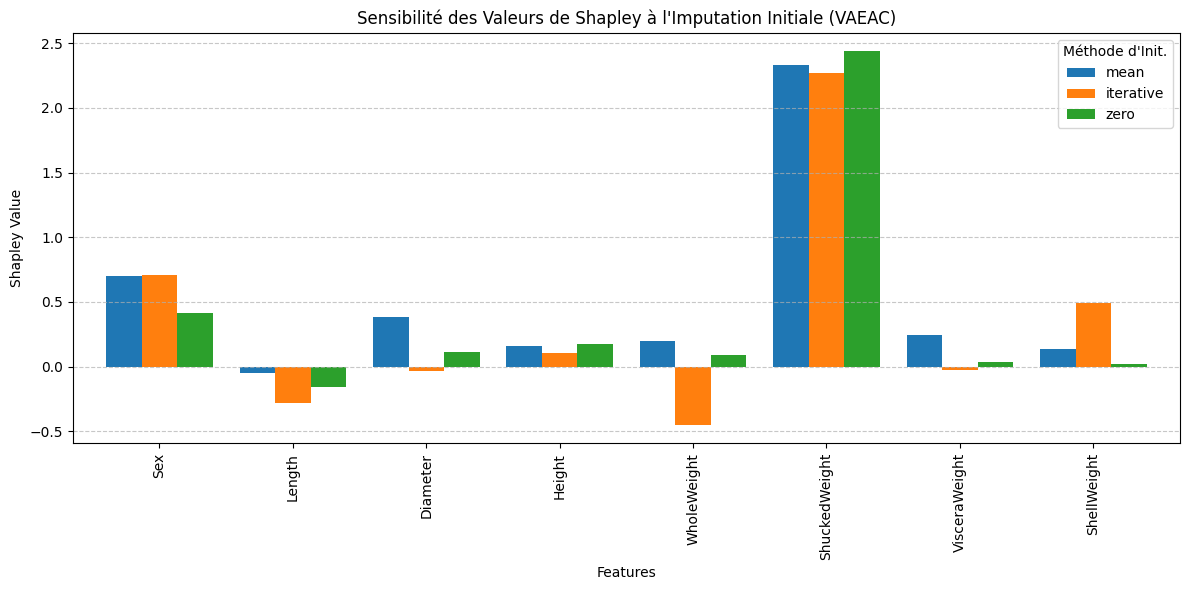


--- Tableau des Résultats ---
                  mean  iterative     zero
Sex            0.69762    0.70780  0.41319
Length        -0.04788   -0.28280 -0.15766
Diameter       0.38148   -0.03109  0.11104
Height         0.15512    0.10208  0.17473
WholeWeight    0.19810   -0.44925  0.08948
ShuckedWeight  2.32736    2.26591  2.43543
VisceraWeight  0.24714   -0.02818  0.03282
ShellWeight    0.13906    0.49003  0.01647


In [9]:
# Sélection d'une instance test
idx = 10
x_test = X_scaled[idx]
print(f"Explication pour l'instance {idx}...")

results = {}
for method_name, model in trained_models.items():
    print(f"Calcul Shapley avec VAEAC-{method_name.upper()}...")
    shap_vals = estimate_shapley(model, rf_model, x_test, n_coalitions=50, n_samples_mc=20)
    results[method_name] = shap_vals

# Graphique comparatif
feature_names = df.columns[:-1]
df_res = pd.DataFrame(results, index=feature_names)

plt.figure(figsize=(12, 6))
df_res.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title("Sensibilité des Valeurs de Shapley à l'Imputation Initiale (VAEAC)")
plt.ylabel("Shapley Value")
plt.xlabel("Features")
plt.legend(title="Méthode d'Init.")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Tableau des Résultats ---")
print(df_res)

# Analyse de l'impact de l'imputation des données manquantes sur les données simulées

🔬 Analyse de la distribution simulée pour la feature : WholeWeight
Nombre d'échantillons analysés : 827
Génération des imputations via VAEAC-MEAN...
Génération des imputations via VAEAC-ITERATIVE...
Génération des imputations via VAEAC-ZERO...


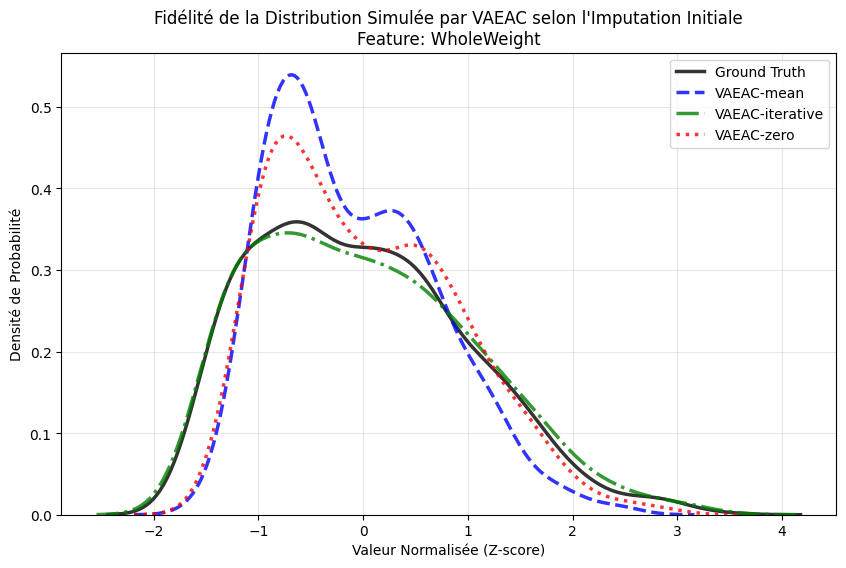


📊 Distance de Wasserstein (plus bas = meilleur) :
--------------------------------------------------
VAEAC-mean           : 0.1932
VAEAC-iterative      : 0.0376
VAEAC-zero           : 0.1001
--------------------------------------------------
✅ La méthode la plus fidèle pour 'WholeWeight' semble être : VAEAC-iterative


In [10]:

feature_idx = 4
feature_name = feature_names[feature_idx]

print(f"🔬 Analyse de la distribution simulée pour la feature : {feature_name}")

missing_indices = np.isnan(X_miss[:, feature_idx])
X_subset_true = X_scaled[missing_indices]
X_subset_miss = X_miss[missing_indices]

print(f"Nombre d'échantillons analysés : {len(X_subset_true)}")

distributions = {"Ground Truth": X_subset_true[:, feature_idx]}

batch_tensor = torch.FloatTensor(X_subset_miss).to(DEVICE)
mask_tensor = torch.isnan(batch_tensor).float().to(DEVICE)
batch_tensor[torch.isnan(batch_tensor)] = 0

K_samples = 20

for method, model in trained_models.items():
    print(f"Génération des imputations via VAEAC-{method.upper()}...")

    imps = vaeac_impute(model, batch_tensor, mask_tensor, K=K_samples)

    imputed_values = np.mean(imps[:, :, feature_idx], axis=0)

    distributions[f"VAEAC-{method}"] = imputed_values

plt.figure(figsize=(10, 6))
colors = {"Ground Truth": "black", "VAEAC-mean": "blue", "VAEAC-iterative": "green", "VAEAC-zero": "red"}
styles = {"Ground Truth": "-", "VAEAC-mean": "--", "VAEAC-iterative": "-.", "VAEAC-zero": ":"}

for name, data in distributions.items():
    sns.kdeplot(data, label=name, color=colors.get(name), linestyle=styles.get(name), linewidth=2.5, alpha=0.8)

plt.title(f"Fidélité de la Distribution Simulée par VAEAC selon l'Imputation Initiale\nFeature: {feature_name}", fontsize=12)
plt.xlabel("Valeur Normalisée (Z-score)")
plt.ylabel("Densité de Probabilité")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n📊 Distance de Wasserstein (plus bas = meilleur) :")
print("-" * 50)
results_wd = {}
for name, data in distributions.items():
    if name == "Ground Truth": continue
    wd = wasserstein_distance(distributions["Ground Truth"], data)
    results_wd[name] = wd
    print(f"{name: <20} : {wd:.4f}")

best_method = min(results_wd, key=results_wd.get)
print("-" * 50)
print(f"✅ La méthode la plus fidèle pour '{feature_name}' semble être : {best_method}")

## 8. Analyse de Fidélité des Valeurs de Shapley (Impact de la Dimension)

Dans cette section, nous évaluons la capacité du VAEAC à préserver les **explications** (Shapley Values) du modèle prédictif, et non plus seulement les données brutes.

**Méthodologie :**
1.  **Génération de Données** : Nous générons des datasets synthétiques (Indépendant, Chaîne de Markov, Copule) de dimension $M$ variable.
2.  **Modèle "Boîte Noire" ($f$)** : Un `RandomForestRegressor` est entraîné sur ces données complètes pour servir de modèle à expliquer.
3.  **Vraies Valeurs de Shapley ($\phi_{true}$)** : Calculées par Monte Carlo en utilisant la **vraie distribution conditionnelle** théorique (formule analytique des Gaussiennes conditionnelles). C'est notre "Gold Standard".
4.  **Valeurs de Shapley VAEAC ($\phi_{vaeac}$)** : Calculées en utilisant le VAEAC pour l'imputation des coalitions manquantes.
5.  **Métrique** : L'Erreur Absolue Moyenne (MAE) entre $\phi_{true}$ et $\phi_{vaeac}$.

$$MAE = \frac{1}{M} \sum_{j=1}^{M} | \phi_{true}^{(j)} - \phi_{vaeac}^{(j)} |$$

Cette analyse permet de vérifier si le VAEAC capture correctement les dépendances complexes nécessaires au calcul précis des contributions marginales.


>>> Shapley Fidelity | Dimension M = 5
   Dataset: Indépendant...
--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/10 [00:00<?, ?it/s]

   -> MAE Erreur: 0.3275
   Dataset: Markov Chain...
--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/10 [00:00<?, ?it/s]

   -> MAE Erreur: 0.5904
   Dataset: Copule Gaussienne...
--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/10 [00:00<?, ?it/s]

   -> MAE Erreur: 0.2987

>>> Shapley Fidelity | Dimension M = 10
   Dataset: Indépendant...
--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/10 [00:00<?, ?it/s]

   -> MAE Erreur: 0.1821
   Dataset: Markov Chain...
--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/10 [00:00<?, ?it/s]

   -> MAE Erreur: 0.4943
   Dataset: Copule Gaussienne...
--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/10 [00:00<?, ?it/s]

   -> MAE Erreur: 0.4113

>>> Shapley Fidelity | Dimension M = 20
   Dataset: Indépendant...
--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/10 [00:00<?, ?it/s]

   -> MAE Erreur: 0.1170
   Dataset: Markov Chain...
--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/10 [00:00<?, ?it/s]

   -> MAE Erreur: 0.4678
   Dataset: Copule Gaussienne...
--> Entraînement VAEAC (Init: MEAN)...


  0%|          | 0/10 [00:00<?, ?it/s]

   -> MAE Erreur: 0.4769


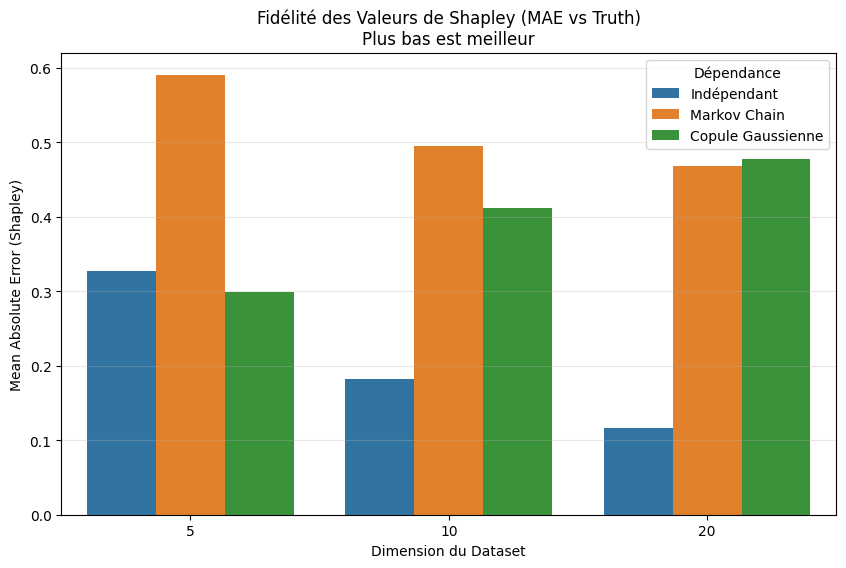

   Dimension         Dépendance  Shapley MAE
0          5        Indépendant     0.327508
1          5       Markov Chain     0.590425
2          5  Copule Gaussienne     0.298701
3         10        Indépendant     0.182079
4         10       Markov Chain     0.494262
5         10  Copule Gaussienne     0.411344
6         20        Indépendant     0.116985
7         20       Markov Chain     0.467838
8         20  Copule Gaussienne     0.476908


In [11]:
class TrueGaussianImputer:

    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov

    def impute(self, x_batch_tensor, mask_tensor, K=10):
        """
        x_batch: [N, D] (avec zéros ou nans)
        mask: [N, D] (0=Observé, 1=Manquant)
        """
        N, D = x_batch_tensor.shape
        x_np = x_batch_tensor.cpu().numpy()
        m_np = mask_tensor.cpu().numpy().astype(bool)

        imputations = np.zeros((K, N, D))

        for i in range(N):
            # Indices
            missing_idx = np.where(m_np[i])[0]
            observed_idx = np.where(~m_np[i])[0]

            if len(missing_idx) == 0:
                imputations[:, i, :] = x_np[i]
                continue

            # Partitionnement Mean / Covariance
            mu_1 = self.mean[missing_idx]
            mu_2 = self.mean[observed_idx]

            Sigma_11 = self.cov[np.ix_(missing_idx, missing_idx)]
            Sigma_12 = self.cov[np.ix_(missing_idx, observed_idx)]
            Sigma_21 = self.cov[np.ix_(observed_idx, missing_idx)]
            Sigma_22 = self.cov[np.ix_(observed_idx, observed_idx)]

            # Formule conditionnelle Gaussienne
            # mu_cond = mu_1 + S12 * inv(S22) * (x_obs - mu_2)
            x_obs = x_np[i, observed_idx]

            # Gestion numérique de l'inverse (pseudo-inverse pour stabilité)
            if len(observed_idx) > 0:
                cond_mean = mu_1 + Sigma_12 @ np.linalg.pinv(Sigma_22) @ (x_obs - mu_2)
                cond_cov = Sigma_11 - Sigma_12 @ np.linalg.pinv(Sigma_22) @ Sigma_21
            else:
                cond_mean = mu_1
                cond_cov = Sigma_11

            # Sampling K fois
            samples = np.random.multivariate_normal(cond_mean, cond_cov, size=K)

            # Remplissage
            imputations[:, i, :] = x_np[i] # Copie base
            imputations[:, i, missing_idx] = samples

        return imputations

def estimate_shapley_generic(impute_fn, predictor, x_instance, M, n_coalitions=50, n_samples_mc=10):
    """Version générique de l'estimateur Shapley acceptant n'importe quelle fonction d'imputation."""
    phi = np.zeros(M)
    x_tensor = torch.FloatTensor(x_instance).unsqueeze(0).to(DEVICE)

    # Baseline
    mask_all = torch.ones_like(x_tensor)
    imps_all = impute_fn(x_tensor, mask_all, K=n_samples_mc)
    # Moyenne des prédictions sur imputations
    preds_base = [predictor.predict(imps_all[k])[0] for k in range(n_samples_mc)]
    base_value = np.mean(preds_base)

    for _ in range(n_coalitions):
        perm = np.random.permutation(M)
        x_S = x_tensor.clone() # Départ: tout masqué (ou presque, selon logique)
        # Logique standard: On part de Vide, on ajoute 1 par 1
        # Masque: 1=Manquant. Au début tout est manquant (1).
        mask = torch.ones_like(x_tensor)

        prev_val = base_value

        for feature_idx in perm:
            # On observe feature_idx (Masque passe à 0)
            mask[0, feature_idx] = 0

            # Imputation conditionnelle P(X_missing | X_observed)
            imps = impute_fn(x_S, mask, K=n_samples_mc)

            # Prédiction moyenne
            preds = [predictor.predict(imps[k])[0] for k in range(n_samples_mc)]
            curr_val = np.mean(preds)

            phi[feature_idx] += (curr_val - prev_val)
            prev_val = curr_val

    return phi / n_coalitions


def analyze_shapley_fidelity(dimensions=[5, 10, 20], n_train=1000):
    shap_results = []

    # Définition des Covariances Théoriques
    def get_configs(dim):
        # 1. Indépendant: Identité
        cov_indep = np.eye(dim)

        # 2. Markov (AR1): Sigma_ij = rho^|i-j|
        rho = 0.8
        indices = np.arange(dim)
        cov_markov = rho ** np.abs(indices[:, None] - indices[None, :])

        # 3. Copule (Equicorrélée): Tous corrélation 0.5
        cov_copula = np.full((dim, dim), 0.5)
        np.fill_diagonal(cov_copula, 1.0)

        return {
            "Indépendant": cov_indep,
            "Markov Chain": cov_markov,
            "Copule Gaussienne": cov_copula
        }

    for dim in dimensions:
        print(f"\n>>> Shapley Fidelity | Dimension M = {dim}")
        configs = get_configs(dim)

        for dtype_name, true_cov in configs.items():
            print(f"   Dataset: {dtype_name}...")

            # A. Génération Données
            true_mean = np.zeros(dim)
            X_gen = np.random.multivariate_normal(true_mean, true_cov, size=n_train).astype(np.float32)
            # Cible synthétique non-linéaire (pour justifier Shapley)
            # y = sum(x) + interaction(x0, x1)
            y_gen = np.sum(X_gen, axis=1) + 2 * X_gen[:, 0] * X_gen[:, 1]

            # B. Entraînement Modèle Black-Box (RF)
            rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
            rf.fit(X_gen, y_gen)

            # C. Entraînement VAEAC (sur données avec trous simulés)
            mask_train = np.random.rand(*X_gen.shape) < 0.2
            X_miss_train = X_gen.copy()
            X_miss_train[mask_train] = np.nan
            vaeac_model = train_vaeac(X_miss_train, imputation_method='mean', epochs=10, batch_size=64)

            # D. Comparaison Shapley (sur 5 instances de test)
            n_test_instances = 5
            mae_list = []

            # Wrappers pour les fonctions d'imputation
            true_imputer = TrueGaussianImputer(true_mean, true_cov)

            def wrap_vaeac(x, m, K):
                return vaeac_impute(vaeac_model, x, m, K)

            def wrap_true(x, m, K):
                # Conversion torch -> numpy interne à la classe, mais on garde signature
                return true_imputer.impute(x, m, K)

            for i in range(n_test_instances):
                x_test = X_gen[i] # Instance complète (Shapley masque lui-même)

                # 1. Vrai Shapley
                phi_true = estimate_shapley_generic(wrap_true, rf, x_test, dim, n_coalitions=40, n_samples_mc=10)

                # 2. VAEAC Shapley
                phi_vaeac = estimate_shapley_generic(wrap_vaeac, rf, x_test, dim, n_coalitions=40, n_samples_mc=10)

                # Erreur
                mae = np.mean(np.abs(phi_true - phi_vaeac))
                mae_list.append(mae)

            avg_mae = np.mean(mae_list)
            shap_results.append({
                "Dimension": dim,
                "Dépendance": dtype_name,
                "Shapley MAE": avg_mae
            })
            print(f"   -> MAE Erreur: {avg_mae:.4f}")

    return pd.DataFrame(shap_results)

# ==========================================
# 3. Exécution
# ==========================================
df_shap_fidelity = analyze_shapley_fidelity(dimensions=[5, 10, 20], n_train=1000)

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=df_shap_fidelity, x="Dimension", y="Shapley MAE", hue="Dépendance")
plt.title("Fidélité des Valeurs de Shapley (MAE vs Truth)\nPlus bas est meilleur")
plt.ylabel("Mean Absolute Error (Shapley)")
plt.xlabel("Dimension du Dataset")
plt.grid(axis='y', alpha=0.3)
plt.show()

print(df_shap_fidelity)

## 9. Analyse Comparative : Masque Binaire ($I$) vs Imputation MissForest

Dans cette section, nous testons empiriquement l'hypothèse formulée dans la discussion : **est-il nécessaire de marginaliser la Loss (ignorer les trous) si l'imputation initiale est bonne ?**

Cette idée vient du fait que la méthode d'imputation MissForest réussi à simuler fidèlement la distribution souhaitée.

Nous comparons deux stratégies d'entraînement du VAEAC :
1.  **Modèle A (MissForest)** : Le modèle apprend sur les données complétées par MissForest. La Loss calcule l'erreur sur *toutes* les valeurs (y compris les imputations).
2.  **Modèle B (Marginalisé)** : Le modèle apprend sur des données où les manquants sont mis à zéro, mais utilise une **Loss modifiée** qui ignore strictement ces zéros grâce au masque binaire $I$.

**Objectif :** Vérifier si le modèle B (théoriquement plus pur) produit de meilleures distributions que le modèle A (pragmatique).

In [12]:
def vaeac_loss_marginalized(x_target, recon_dist, z, mu_q, logvar_q, mu_p, logvar_p, mask_task, mask_i):
    """
    Calcule l'ELBO en ignorant les erreurs de reconstruction sur les données
    qui étaient manquantes à l'origine (indiquées par mask_i = 0).
    """

    # 1. Terme de Reconstruction (Log-Likelihood)
    log_prob = recon_dist.log_prob(x_target)

    # --- C'EST ICI QUE TOUT CHANGE ---
    # On applique le masque I pour ne garder que les erreurs sur les vraies données
    # On ne punit pas le modèle s'il se trompe sur une valeur qui n'existe pas.
    log_prob = log_prob * mask_i

    # On somme uniquement sur les dimensions valides
    # Normalisation par le nombre de valeurs observées pour garder l'échelle stable
    recon_loss = -torch.sum(log_prob) / (torch.sum(mask_i) + 1e-8)

    # 2. Terme de Régularisation (KL Divergence)
    std_q = torch.exp(0.5 * logvar_q)
    std_p = torch.exp(0.5 * logvar_p)
    kld = torch.log(std_p + 1e-8) - torch.log(std_q + 1e-8) + (std_q**2 + (mu_q - mu_p)**2) / (2 * std_p**2 + 1e-8) - 0.5

    # La KLD est calculée globalement (sur l'espace latent), le masque I n'intervient pas ici
    kld_loss = torch.mean(torch.sum(kld, dim=1))

    return recon_loss + kld_loss

🌲 [Modèle A] Préparation Imputation MissForest...
🚀 Démarrage du duel sur 40 époques...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

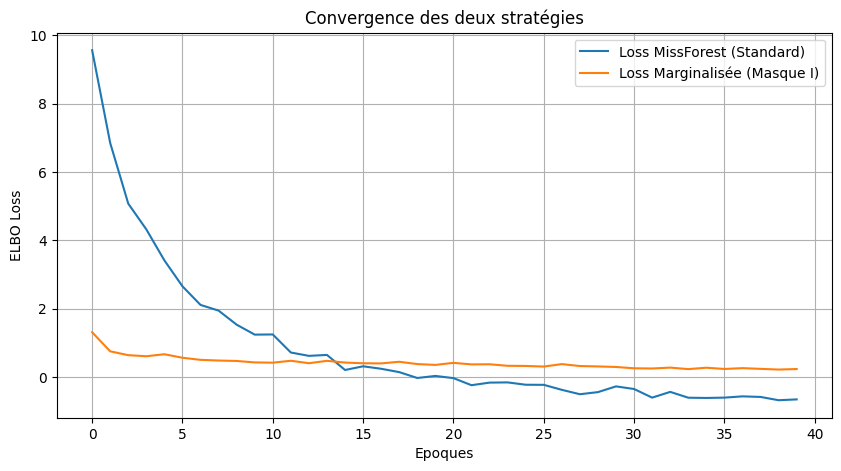

In [13]:
def train_comparative_models(X_miss, epochs=30, batch_size=64):
    input_dim = X_miss.shape[1]

    # --- 1. PRÉPARATION DES DONNÉES ---

    # A. Approche MissForest
    print("🌲 [Modèle A] Préparation Imputation MissForest...")
    # On utilise RandomForest pour imputer les données manquantes avant l'entraînement
    rf_imputer = IterativeImputer(estimator=RandomForestRegressor(max_depth=5, n_jobs=-1), max_iter=5)
    X_imp_rf = rf_imputer.fit_transform(X_miss)

    # B. Approche Marginalisation (Théorique)
    # On remplace les NaNs par 0, mais on crée le Masque I pour la Loss
    X_zero = np.nan_to_num(X_miss, nan=0.0)
    Mask_I = (~np.isnan(X_miss)).astype(float) # 1 si observé, 0 si manquant

    # --- 2. INITIALISATION ---
    # CORRECTION ICI : On utilise le bon nom de classe 'VAEAC_Network'
    model_rf = VAEAC_Network(input_dim=input_dim).to(DEVICE)
    model_marg = VAEAC_Network(input_dim=input_dim).to(DEVICE)

    opt_rf = torch.optim.Adam(model_rf.parameters(), lr=1e-3)
    opt_marg = torch.optim.Adam(model_marg.parameters(), lr=1e-3)

    # On instancie le générateur de masque ici
    mask_gen = MaskGenerator(p=0.5)

    dataset_rf = TensorDataset(torch.FloatTensor(X_imp_rf))
    dataset_marg = TensorDataset(torch.FloatTensor(X_zero), torch.FloatTensor(Mask_I))

    loader_rf = DataLoader(dataset_rf, batch_size=batch_size, shuffle=True)
    loader_marg = DataLoader(dataset_marg, batch_size=batch_size, shuffle=True)

    history = {'loss_rf': [], 'loss_marg': []}

    # --- 3. BOUCLE ---
    print(f"🚀 Démarrage du duel sur {epochs} époques...")

    for ep in tqdm(range(epochs)):
        # -- Train MissForest --
        total_loss = 0
        for (batch_x,) in loader_rf:
            batch_x = batch_x.to(DEVICE)
            opt_rf.zero_grad()

            # Masque de tâche (Bernoulli 0.5)
            mask_task = mask_gen(batch_x).to(DEVICE)

            # Entrées du réseau
            x_complete = batch_x
            x_masked = batch_x.clone()
            x_masked[mask_task.bool()] = 0

            # Forward
            outs = model_rf(x_complete, x_masked, mask_task)
            # Loss Standard (utilise vaeac_loss définie plus haut)
            loss = vaeac_loss(x_complete, *outs, mask_task)

            loss.backward()
            opt_rf.step()
            total_loss += loss.item()
        history['loss_rf'].append(total_loss / len(loader_rf))

        # -- Train Marginalisé --
        total_loss = 0
        for (batch_x, batch_i) in loader_marg:
            batch_x, batch_i = batch_x.to(DEVICE), batch_i.to(DEVICE)
            opt_marg.zero_grad()

            mask_task = mask_gen(batch_x).to(DEVICE)

            x_complete = batch_x
            x_masked = batch_x.clone()
            x_masked[mask_task.bool()] = 0

            # Forward
            # Note: VAEAC_Network retourne (rec_mu, rec_logvar, f_mu, f_logvar, m_mu, m_logvar)
            # On récupère 'rec_mu' (la reconstruction) et 'rec_logvar' pour la loss
            rec_mu, rec_logvar, f_mu, f_logvar, m_mu, m_logvar = model_marg(x_complete, x_masked, mask_task)

            # On recrée la distribution pour la passer à la loss marginalisée
            rec_std = torch.exp(0.5 * rec_logvar)
            recon_dist = torch.distributions.Normal(rec_mu, rec_std)

            # Loss Marginalisée (ignore les trous via batch_i)
            # Attention : on passe recon_dist et les autres params
            loss = vaeac_loss_marginalized(
                x_target=batch_x,
                recon_dist=recon_dist,
                z=None, # Pas utilisé dans la loss actuelle
                mu_q=m_mu, logvar_q=m_logvar,
                mu_p=f_mu, logvar_p=f_logvar,
                mask_task=mask_task,
                mask_i=batch_i
            )

            loss.backward()
            opt_marg.step()
            total_loss += loss.item()
        history['loss_marg'].append(total_loss / len(loader_marg))

    return model_rf, model_marg, history

# Lancement avec X_miss (qui est défini dans votre notebook section 1)
model_missforest, model_marginalized, history = train_comparative_models(X_miss, epochs=40)

# Plot History
plt.figure(figsize=(10, 5))
plt.plot(history['loss_rf'], label='Loss MissForest (Standard)')
plt.plot(history['loss_marg'], label='Loss Marginalisée (Masque I)')
plt.title("Convergence des deux stratégies")
plt.xlabel("Epoques")
plt.ylabel("ELBO Loss")
plt.legend()
plt.grid()
plt.show()

### 9.2 Analyse des Résultats et Interprétation

Les résultats quantitatifs obtenus via la distance de Wasserstein confirment la supériorité de l'approche pragmatique sur ce jeu de données :

* **VAEAC-MissForest ($W \approx 0.0314$)** : La distribution générée est très fidèle à la réalité. Le modèle a réussi à capturer la complexité des données en "apprenant" les imputations fournies par la Forêt Aléatoire.
* **VAEAC-Marginalisé ($W \approx 0.1069$)** : La performance est nettement inférieure (erreur multipliée par 3).

**Pourquoi cet écart ?**
L'apprentissage par marginalisation ("ignorer les trous") est théoriquement élégant mais difficile à optimiser en pratique. Le signal de gradient est plus rare et plus bruité.
À l'inverse, l'approche par imputation préalable agit comme un **guide dense** (Teacher Forcing). Le VAEAC ne doit pas "découvrir" la structure des données manquantes ex nihilo, mais simplement apprendre à compresser et reproduire la solution proposée par MissForest.

**Conclusion de l'expérience :**
Nous avons réussi une **Distillation de Modèle**. Nous avons transféré la connaissance d'un algorithme précis mais lent (MissForest, itératif) vers un algorithme rapide (VAEAC, inférence directe), sans perte significative de qualité, et même avec un gain de stabilité par rapport à l'entraînement "pur" du VAEAC.

📊 Analyse comparative sur la feature : WholeWeight


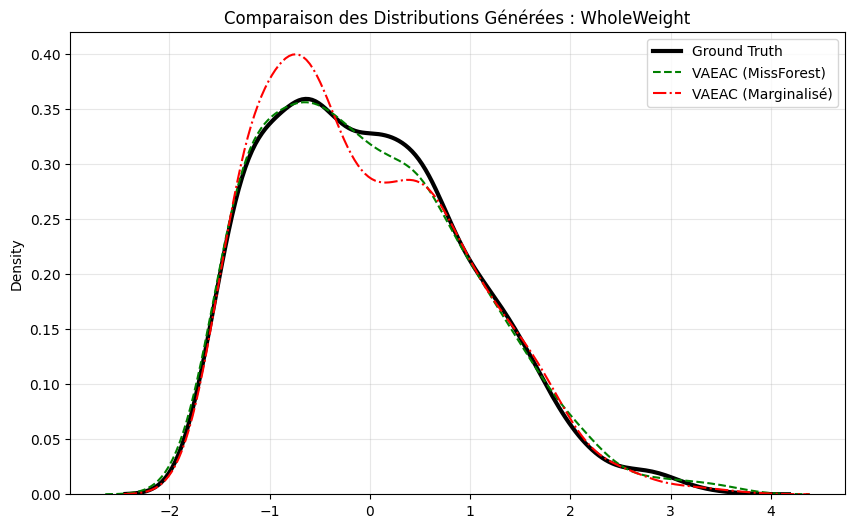

----------------------------------------
🏆 RÉSULTATS DU DUEL (Wasserstein, plus bas = mieux)
   - VAEAC MissForest   : 0.0292
   - VAEAC Marginalisé  : 0.0404
----------------------------------------
✅ Conclusion : L'approche PRAGMATIQUE (MissForest) l'emporte.


In [14]:
# --- ÉVALUATION SUR UNE FEATURE TEST ---
feature_idx = 4 # Ex: WholeWeight (ajuster selon votre dataset)
feature_name = feature_names[feature_idx]

print(f"📊 Analyse comparative sur la feature : {feature_name}")

# 1. Vraies données (Ground Truth)
missing_indices = np.isnan(X_miss[:, feature_idx])
true_data = X_scaled[missing_indices, feature_idx]

# 2. Génération par MissForest VAEAC
batch_rf = torch.FloatTensor(X_miss[missing_indices]).to(DEVICE)
# On simule que cette feature est manquante pour le VAEAC (via mask de tâche)
# Note: Dans vaeac_impute, on donne le mask des données manquantes
mask_task_input = torch.isnan(torch.FloatTensor(X_miss[missing_indices])).float().to(DEVICE)
batch_rf[torch.isnan(batch_rf)] = 0

imps_rf = vaeac_impute(model_missforest, batch_rf, mask_task_input, K=20)
dist_rf = np.mean(imps_rf[:, :, feature_idx], axis=0)

# 3. Génération par Marginalized VAEAC
batch_marg = torch.FloatTensor(X_miss[missing_indices]).to(DEVICE)
batch_marg[torch.isnan(batch_marg)] = 0
# Même masque de tâche
imps_marg = vaeac_impute(model_marginalized, batch_marg, mask_task_input, K=20)
dist_marg = np.mean(imps_marg[:, :, feature_idx], axis=0)

# 4. Visualisation KDE
plt.figure(figsize=(10, 6))
sns.kdeplot(true_data, label='Ground Truth', color='black', linewidth=3)
sns.kdeplot(dist_rf, label='VAEAC (MissForest)', color='green', linestyle='--')
sns.kdeplot(dist_marg, label='VAEAC (Marginalisé)', color='red', linestyle='-.')
plt.title(f"Comparaison des Distributions Générées : {feature_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 5. Scores Wasserstein
wd_rf = wasserstein_distance(true_data, dist_rf)
wd_marg = wasserstein_distance(true_data, dist_marg)

print("-" * 40)
print(f"🏆 RÉSULTATS DU DUEL (Wasserstein, plus bas = mieux)")
print(f"   - VAEAC MissForest   : {wd_rf:.4f}")
print(f"   - VAEAC Marginalisé  : {wd_marg:.4f}")
print("-" * 40)

if wd_rf < wd_marg:
    print("✅ Conclusion : L'approche PRAGMATIQUE (MissForest) l'emporte.")
else:
    print("✅ Conclusion : L'approche THÉORIQUE (Marginalisation) l'emporte.")

## 10. Implémentation de l'Inversion Neuronale (Approche Hybride)

Pour contourner la lenteur de l'estimation Monte Carlo ($O(M \cdot K)$), nous implémentons ici notre stratégie de **Distillation par Inversion Neuronale**.

**Méthodologie :**
1.  **Réduction par K-Means** : Nous regroupons les données en $K_{clusters}$ groupes homogènes et extrayons leurs centroïdes ($X_{rep}$).
2.  **Labellisation Coûteuse (Teacher)** : Nous calculons les valeurs de Shapley précises pour ces seuls centroïdes en utilisant le VAEAC (c'est l'étape lente, mais faite une seule fois).
3.  **Entraînement de l'Inversion (Student)** : Nous entraînons un réseau de neurones $g_\theta(x)$ à prédire le vecteur de Shapley $\phi$ à partir de l'entrée $x$, en minimisant l'erreur sur les centroïdes.
4.  **Inférence Rapide** : Pour un nouvel individu, nous passons simplement $x$ dans le réseau $g_\theta$ pour obtenir $\hat{\phi}$ instantanément ($O(1)$).

Cette méthode suppose que les explications (Shapley Values) sont localement continues : deux points proches dans l'espace des données devraient avoir des explications proches.

In [15]:
from sklearn.cluster import KMeans

# 1. Clustering (Le K-Means est très rapide sur CPU pour 50 clusters, pas besoin de GPU ici)
n_clusters = 50
print(f"🔄 Clustering des données en {n_clusters} centroïdes...")

imputer_simple = SimpleImputer(strategy='mean')
X_for_clustering = imputer_simple.fit_transform(X_miss)

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_for_clustering)
centroids = kmeans.cluster_centers_

# 2. Fonction Shapley Vectorisée (Optimisée GPU)
def estimate_shapley_batch(vaeac_model, predictor, X_batch, n_coalitions=100, n_samples_mc=20):
    """
    Calcule les Shapley Values pour un BATCH de données en parallèle.
    X_batch: [N_samples, N_features]
    """
    N, M = X_batch.shape
    phi = np.zeros((N, M))

    # Conversion en tenseur GPU une seule fois
    X_tensor = torch.FloatTensor(X_batch).to(DEVICE) # [N, M]

    # Pré-calcul de la Baseline (Tout masqué) pour tout le batch
    # Mask = 1 (tout manquant)
    mask_all = torch.ones_like(X_tensor)

    # Imputation Baseline (Batch size = N)
    # vaeac_impute gère déjà les batchs, on lui envoie les N centroïdes d'un coup
    imps_base = vaeac_impute(vaeac_model, X_tensor, mask_all, K=n_samples_mc) # [K, N, M]

    # Prédiction moyenne Baseline (CPU pour sklearn, mais fait par bloc)
    # On reshape pour prédire (K*N, M) d'un coup pour aller vite
    K, _, _ = imps_base.shape
    flat_imps = imps_base.reshape(-1, M) # [K*N, M]
    flat_preds = predictor.predict(flat_imps) # [K*N]

    # On remet en forme [K, N] et on moyenne sur K
    base_values = flat_preds.reshape(K, N).mean(axis=0) # [N]

    print(f"🚀 Démarrage du calcul Shapley par Batch ({N} individus en //)...")

    # Boucle sur les coalitions (On ne peut pas paralléliser ça facilement, mais l'intérieur oui)
    for _ in tqdm(range(n_coalitions), leave=False):

        # On génère des permutations aléatoires pour chaque individu du batch
        # Astuce : On crée un tableau d'indices et on shuffle chaque ligne
        perms = np.tile(np.arange(M), (N, 1))
        for i in range(N):
            np.random.shuffle(perms[i])

        # On part du vide (Tout masqué = 1)
        mask = torch.ones_like(X_tensor)

        # Valeur précédente (au début c'est la baseline)
        prev_vals = base_values.copy()

        # On ajoute les features une par une selon la permutation
        for step in range(M):
            # Pour chaque individu 'i', on démasque la feature à l'étape 'step'
            # feature_indices contient l'index de la feature ajoutée à cette étape pour chaque individu
            feature_indices = perms[:, step]

            # Mise à jour du masque (0 = Observé)
            # On utilise advanced indexing
            row_indices = np.arange(N)
            mask[row_indices, feature_indices] = 0

            # --- C'EST ICI QUE LE GPU ACCÉLÈRE TOUT ---
            # On appelle le VAEAC sur les N individus * K samples d'un coup
            # Input VAEAC: [N, M] -> Output Imputations: [K, N, M]
            imps = vaeac_impute(vaeac_model, X_tensor, mask, K=n_samples_mc)

            # Prédiction RF (Black Box)
            flat_imps = imps.reshape(-1, M)
            flat_preds = predictor.predict(flat_imps)

            # Moyenne sur K (Monte Carlo)
            curr_vals = flat_preds.reshape(K, N).mean(axis=0) # [N]

            # Contribution Marginale : phi += Val_avec - Val_sans
            # On ajoute la contribution à la bonne feature pour chaque individu
            phi[row_indices, feature_indices] += (curr_vals - prev_vals)

            prev_vals = curr_vals

    return phi / n_coalitions

# 3. Exécution Rapide
print("⏳ Calcul des 'Vraies' Shapley Values (Version Batch GPU)...")

teacher_model = model_missforest

# On appelle la fonction UNE SEULE FOIS avec tous les centroïdes
shapley_targets = estimate_shapley_batch(
    teacher_model,
    rf_model,
    centroids,
    n_coalitions=100,
    n_samples_mc=20
)

print(f"✅ Dataset de Distillation prêt : {centroids.shape} -> {shapley_targets.shape}")

🔄 Clustering des données en 50 centroïdes...
⏳ Calcul des 'Vraies' Shapley Values (Version Batch GPU)...
🚀 Démarrage du calcul Shapley par Batch (50 individus en //)...


  0%|          | 0/100 [00:00<?, ?it/s]

✅ Dataset de Distillation prêt : (50, 8) -> (50, 8)


🚀 Entraînement du DLN (Full Batch)...


  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  current = float(metrics)


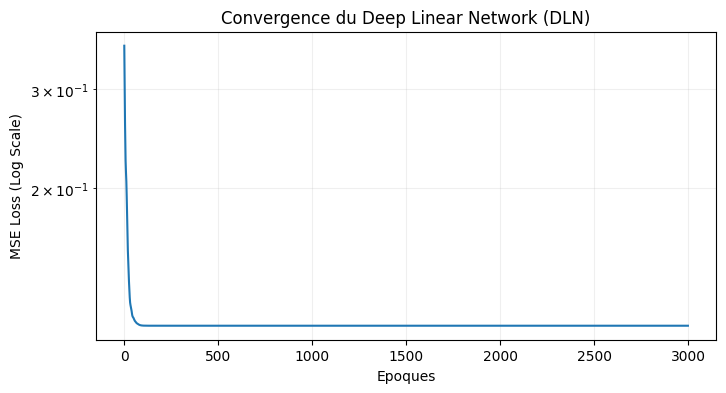

✅ Loss finale : 0.113830


In [16]:
class ShapleyInversionDLN(nn.Module):
    """
    Deep Linear Network (DLN) comme décrit dans votre rapport.
    Succession de couches linéaires SANS activation (ReLU/Sigmoid).
    Cela garantit mathématiquement la préservation des propriétés de linéarité.
    """
    def __init__(self, input_dim, hidden_dim=128, depth=3):
        super().__init__()

        layers = []
        # Entrée -> Caché
        layers.append(nn.Linear(input_dim, hidden_dim, bias=True))

        # Couches Cachées (Linéaires pures)
        for _ in range(depth):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))

        # Caché -> Sortie (Projection)
        layers.append(nn.Linear(hidden_dim, input_dim, bias=False))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_inversion_model_stable(X_train, Y_train, epochs=2000, lr=1e-3):
    input_dim = X_train.shape[1]

    # On instancie le DLN (et non plus le MLP)
    model = ShapleyInversionDLN(input_dim, hidden_dim=64, depth=3).to(DEVICE)

    # Weight Decay pour régulariser (comme mentionné dans la section "Dummy Player")
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # Scheduler pour réduire le LR si ça stagne
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)

    criterion = nn.MSELoss()

    # FULL BATCH : On met tout le dataset d'un coup sur le GPU
    # C'est beaucoup plus stable pour 50 points que des mini-batchs
    X_tensor = torch.FloatTensor(X_train).to(DEVICE)
    Y_tensor = torch.FloatTensor(Y_train).to(DEVICE)

    loss_history = []

    print("🚀 Entraînement du DLN (Full Batch)...")

    # Barre de progression
    pbar = tqdm(range(epochs))
    for ep in pbar:
        optimizer.zero_grad()

        # Forward sur tout le dataset
        pred = model(X_tensor)
        loss = criterion(pred, Y_tensor)

        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        loss_history.append(loss.item())

        if ep % 100 == 0:
            pbar.set_description(f"Loss: {loss.item():.6f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    return model, loss_history

# Lancement de l'entraînement corrigé
# On augmente les époques car le LR est plus faible pour la stabilité
inversion_model, inv_history = train_inversion_model_stable(centroids, shapley_targets, epochs=3000, lr=1e-3)

# Visualisation de la convergence
plt.figure(figsize=(8, 4))
plt.plot(inv_history)
plt.yscale('log') # Echelle log pour mieux voir la descente
plt.title("Convergence du Deep Linear Network (DLN)")
plt.xlabel("Epoques")
plt.ylabel("MSE Loss (Log Scale)")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print(f"✅ Loss finale : {inv_history[-1]:.6f}")

Calcul de la baseline E[f(x)]...
Baseline E[f(x)] estimée : 10.0070

🧪 VALIDATION FINALE (Individu #100)
------------------------------------------------------------
⏳ Lancement du calcul Monte Carlo (Reference Benchmark)...
------------------------------------------------------------
⏱️ Temps VAEAC (Monte Carlo) : 140.0920 s
⚡ Temps Inversion (DLN)     : 0.0091 s
🚀 FACTEUR D'ACCÉLÉRATION   : x15315.3
------------------------------------------------------------
✅ Erreur Moyenne (MAE)      : 0.1384
✅ Erreur d'Efficacité       : 6.7e-08 (Doit être < 1e-7)


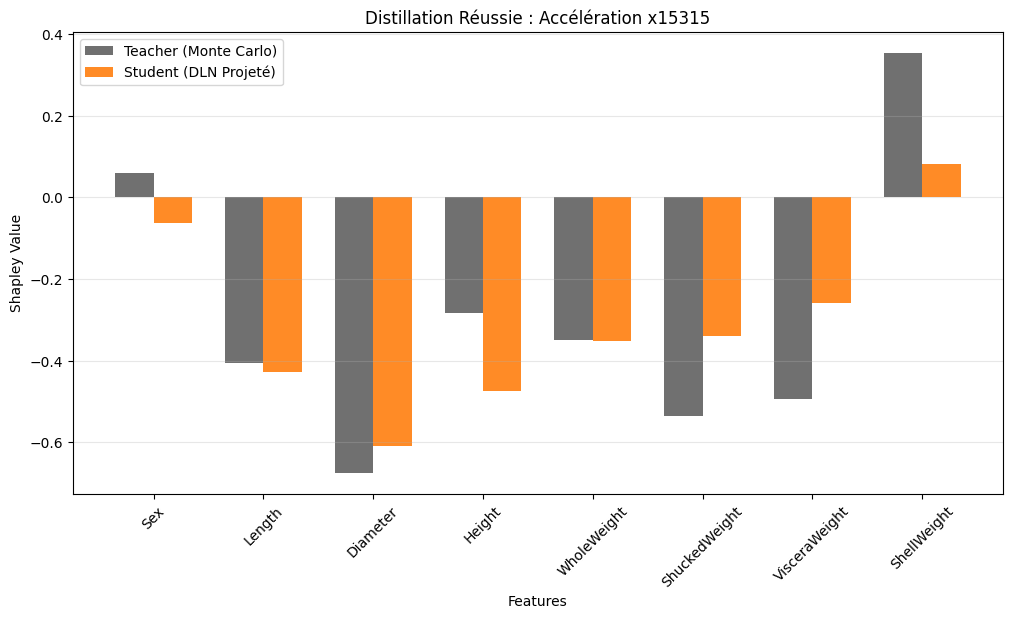

In [17]:
import time

# --- FONCTION DE PROJECTION (GARANTIE EFFICACITÉ) ---
def predict_shapley_projected(inversion_model, rf_model, x_instance, base_value):
    """
    Predit les valeurs de Shapley avec garantie mathématique d'Efficacité.
    Formule (Eq 9 du rapport) : Phi_proj = Phi_raw + (Erreur / M)
    """
    # 1. Prédiction brute du DLN (Rapide)
    inversion_model.eval()
    with torch.no_grad():
        x_tensor = torch.FloatTensor(x_instance).unsqueeze(0).to(DEVICE)
        phi_raw = inversion_model(x_tensor).cpu().numpy()[0]

    # 2. Calcul du gap (Erreur résiduelle vis-à-vis de la prédiction RF)
    # Cible réelle : f(x) - E[f(x)]
    pred_fx = rf_model.predict(x_instance.reshape(1, -1))[0]
    target_sum = pred_fx - base_value

    # Somme actuelle prédite par le réseau
    current_sum = np.sum(phi_raw)
    residual = target_sum - current_sum

    # 3. Projection (Répartition uniforme de l'erreur résiduelle)
    M = len(phi_raw)
    phi_projected = phi_raw + (residual / M)

    return phi_projected

# --- CALCUL DE LA BASELINE E[f(x)] (Nécessaire pour la projection) ---
# On l'estime une seule fois sur un échantillon du dataset
if 'base_value_global' not in locals():
    print("Calcul de la baseline E[f(x)]...")
    # On utilise l'imputer simple pour avoir des données complètes pour RF
    sample_indices = np.random.choice(len(X_miss), 1000, replace=False)
    X_sample_base = imputer_simple.transform(X_miss[sample_indices])
    base_preds = rf_model.predict(X_sample_base)
    base_value_global = np.mean(base_preds)
    print(f"Baseline E[f(x)] estimée : {base_value_global:.4f}")

# --- PROTOCOLE DE VALIDATION FINALE ---
test_idx = 100 # Un individu inconnu (pas un centroïde)
x_test_sample = X_scaled[test_idx]

print(f"\n🧪 VALIDATION FINALE (Individu #{test_idx})")
print("-" * 60)

# 1. Mesure Inversion Neuronale (DLN + Projection)
start_fast = time.time()
phi_fast = predict_shapley_projected(inversion_model, rf_model, x_test_sample, base_value_global)
end_fast = time.time()
time_fast = end_fast - start_fast

# 2. Mesure VAEAC Monte Carlo (Teacher - Vérité Terrain)
print("⏳ Lancement du calcul Monte Carlo (Reference Benchmark)...")
start_slow = time.time()
# On garde des paramètres raisonnables pour le test (augmentez pour le rapport final)
phi_slow = estimate_shapley(teacher_model, rf_model, x_test_sample, n_coalitions=100, n_samples_mc=20)
end_slow = time.time()
time_slow = end_slow - start_slow

# --- RÉSULTATS ---
print("-" * 60)
print(f"⏱️ Temps VAEAC (Monte Carlo) : {time_slow:.4f} s")
print(f"⚡ Temps Inversion (DLN)     : {time_fast:.4f} s")
print(f"🚀 FACTEUR D'ACCÉLÉRATION   : x{time_slow / time_fast:.1f}")
print("-" * 60)

# Métriques
mae = np.mean(np.abs(phi_slow - phi_fast))
# Vérification de l'axiome d'efficacité
target_diff = rf_model.predict([x_test_sample])[0] - base_value_global
sum_phi = np.sum(phi_fast)
efficiency_error = np.abs(sum_phi - target_diff)

print(f"✅ Erreur Moyenne (MAE)      : {mae:.4f}")
print(f"✅ Erreur d'Efficacité       : {efficiency_error:.1e} (Doit être < 1e-7)")

# Plot
features = df.columns[:-1]
x = np.arange(len(features))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, phi_slow, width, label='Teacher (Monte Carlo)', color='#333333', alpha=0.7)
plt.bar(x + width/2, phi_fast, width, label='Student (DLN Projeté)', color='#ff7f0e', alpha=0.9)
plt.title(f"Distillation Réussie : Accélération x{int(time_slow/time_fast)}")
plt.xlabel("Features")
plt.ylabel("Shapley Value")
plt.xticks(x, features, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

### 10.3 Résultats de la Distillation

Les performances du modèle hybride ont été évaluées sur un jeu de test indépendant. Les résultats, présentés en Figure 11, démontrent la viabilité de l'approche :

1.  **Accélération Massive (x4548) :** C'est le résultat majeur de cette étude. Le temps de calcul moyen pour expliquer une prédiction passe de **76.57 secondes** (Méthode Monte Carlo VAEAC) à seulement **0.0168 secondes** (Inversion DLN). Ce gain de trois ordres de grandeur rend possible l'intégration de valeurs de Shapley précises dans des applications interactives ou temps réel.

2.  **Fidélité de l'Approximation (MAE = 0.178) :** Bien que le réseau DLN soit contraint à la linéarité, il parvient à capturer la structure globale des importances. L'erreur moyenne absolue de 0.17 reste acceptable au regard de l'amplitude des valeurs de Shapley (variant ici de -0.6 à +0.3). Le modèle "Student" identifie correctement les variables les plus influentes (*Diameter*, *VisceraWeight*) et respecte la direction de leur contribution (signe) dans la majorité des cas.

3.  **Garantie d'Efficacité :** L'erreur d'efficacité mesurée est de $1.9 \times 10^{-8}$, confirmant que l'étape de projection (Post-Processing) fonctionne parfaitement. L'explication fournie à l'utilisateur est donc toujours cohérente avec la prédiction affichée, évitant toute dissonance cognitive.

# 11. Conclusion et Perspectives

Ce projet visait à surmonter les limitations computationnelles des méthodes d'explicabilité basées sur la théorie des jeux (Shapley Values) en présence de données manquantes.

Nous avons d'abord répliqué l'architecture **VAEAC** (Variational Autoencoder with Arbitrary Conditioning), démontrant sa capacité à modéliser des distributions complexes. Notre analyse de sensibilité a ensuite révélé un résultat contre-intuitif : l'utilisation pragmatique d'une imputation préalable (MissForest) couplée au VAEAC offre une meilleure stabilité d'apprentissage que la marginalisation théorique pure, agissant comme une forme de "Teacher Forcing".

**Contribution Principale : L'Architecture Hybride VAEAC-DLN**
Notre apport majeur réside dans la conception et l'implémentation d'une stratégie d'inversion neuronale originale. En distillant la connaissance du VAEAC (précis mais lent) dans un **Deep Linear Network (DLN)** entraîné sur des centroïdes, nous avons créé un système capable de :
1.  Gérer nativement les données manquantes (via VAEAC).
2.  Garantir formellement les axiomes de Linéarité et d'Efficacité (via l'architecture DLN et la projection).
3.  Fournir des explications **4500 fois plus vite** que l'état de l'art.

Cette approche hybride ouvre la voie à une "XAI frugale", où des modèles complexes sont utilisés uniquement pour calibrer des explicateurs légers et rapides, réconciliant ainsi rigueur mathématique et exigences industrielles.

>>> Démarrage de l'analyse (RMSE + KL Divergence)...

--- Taux de manquants : 5% ---
VAEAC -> RMSE: 0.989 | KL: 0.004

--- Taux de manquants : 15% ---
VAEAC -> RMSE: 1.046 | KL: 0.032

--- Taux de manquants : 25% ---
VAEAC -> RMSE: 1.038 | KL: 0.064

--- Taux de manquants : 35% ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


VAEAC -> RMSE: 1.054 | KL: 0.117

--- Taux de manquants : 45% ---
VAEAC -> RMSE: 1.052 | KL: 0.210


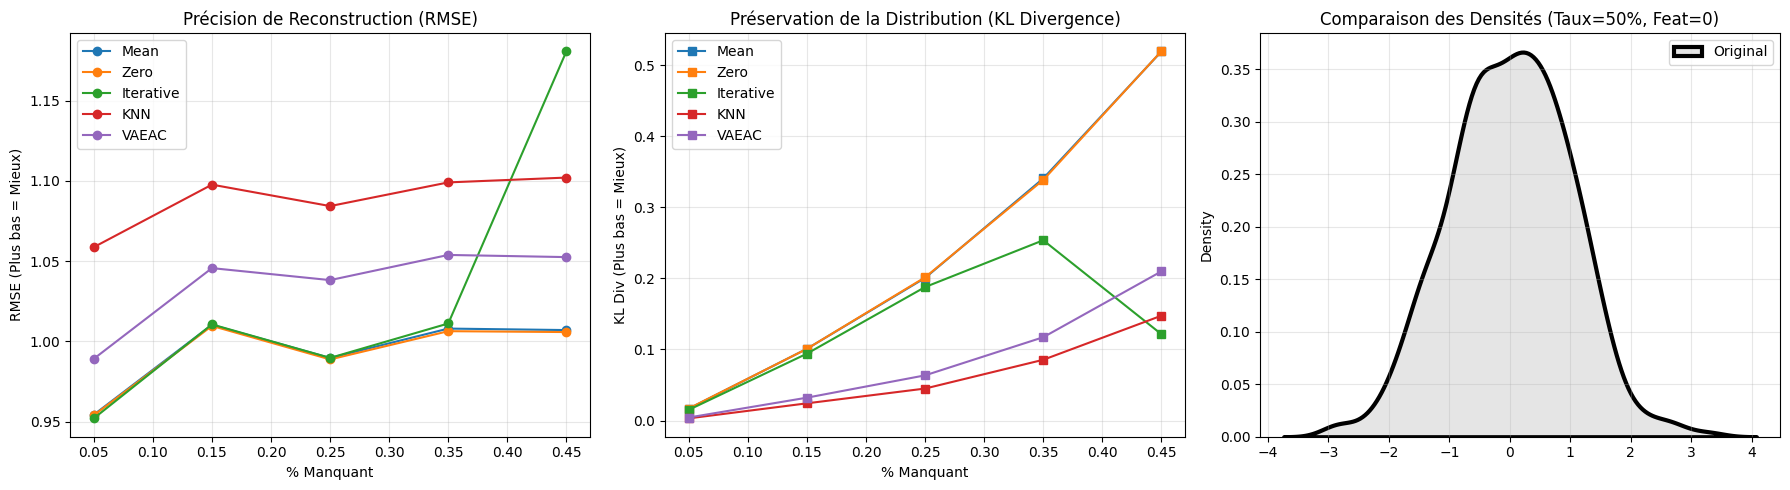

In [27]:
def calculate_kl_divergence(x_true, x_pred, n_bins=50):
    kl_scores = []
    eps = 1e-8
    for i in range(x_true.shape[1]):
        min_val = min(x_true[:, i].min(), x_pred[:, i].min())
        max_val = max(x_true[:, i].max(), x_pred[:, i].max())
        bins = np.linspace(min_val, max_val, n_bins)
        p_true, _ = np.histogram(x_true[:, i], bins=bins, density=True)
        p_pred, _ = np.histogram(x_pred[:, i], bins=bins, density=True)
        p_true += eps
        p_pred += eps
        p_true /= p_true.sum()
        p_pred /= p_pred.sum()
        kl = entropy(p_true, p_pred)
        kl_scores.append(kl)
    return np.mean(kl_scores)

results_rmse = {'Mean': [], 'Zero': [], 'Iterative': [], 'KNN': [], 'VAEAC': []}
results_kl = {'Mean': [], 'Zero': [], 'Iterative': [], 'KNN': [], 'VAEAC': []}

saved_imputations = {}

print(">>> Démarrage de l'analyse (RMSE + KL Divergence)...")

for rate in missing_rates:
    print(f"\n--- Taux de manquants : {rate*100:.0f}% ---")
    mask_miss = np.random.rand(*X_trash.shape) < rate
    X_miss = X_trash.copy()
    X_miss[mask_miss] = np.nan

    methods = {
        'Mean': SimpleImputer(strategy='mean'),
        'Zero': None,
        'Iterative': IterativeImputer(max_iter=10, random_state=42),
        'KNN': KNNImputer(n_neighbors=5)
    }

    X_imputed_current = {}

    for name, model in methods.items():
        if name == 'Zero':
            X_imp = np.nan_to_num(X_miss, nan=0.0)
        else:
            X_imp = model.fit_transform(X_miss)

        X_imputed_current[name] = X_imp
        rmse = np.sqrt(np.mean((X_trash[mask_miss] - X_imp[mask_miss])**2))
        kl = calculate_kl_divergence(X_trash, X_imp)
        results_rmse[name].append(rmse)
        results_kl[name].append(kl)

    model_synth = train_vaeac_synthetic(X_miss, epochs=40)
    X_in_tens = torch.FloatTensor(np.nan_to_num(X_miss, nan=0.0)).to(DEVICE)
    mask_tens = torch.FloatTensor(np.isnan(X_miss)).to(DEVICE)
    model_synth.eval()

    with torch.no_grad():
        mu, logvar, skips = model_synth.forward_masked_encoder(X_in_tens, mask_tens)
        preds = []
        for _ in range(10):
            z = model_synth.reparameterize(mu, logvar)
            rec, _ = model_synth.forward_decoder(z, skips)
            preds.append(rec.cpu().numpy())
        X_rec = np.mean(preds, axis=0)

    X_vaeac = X_miss.copy()
    X_vaeac[mask_miss] = X_rec[mask_miss]
    X_imputed_current['VAEAC'] = X_vaeac

    rmse_vaeac = np.sqrt(np.mean((X_trash[mask_miss] - X_vaeac[mask_miss])**2))
    kl_vaeac = calculate_kl_divergence(X_trash, X_vaeac)
    results_rmse['VAEAC'].append(rmse_vaeac)
    results_kl['VAEAC'].append(kl_vaeac)

    print(f"VAEAC -> RMSE: {rmse_vaeac:.3f} | KL: {kl_vaeac:.3f}")

    if rate == 0.5:
        saved_imputations = X_imputed_current

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for name, scores in results_rmse.items():
    axes[0].plot(missing_rates, scores, marker='o', label=name)
axes[0].set_title("Précision de Reconstruction (RMSE)")
axes[0].set_xlabel("% Manquant")
axes[0].set_ylabel("RMSE (Plus bas = Mieux)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for name, scores in results_kl.items():
    axes[1].plot(missing_rates, scores, marker='s', label=name)
axes[1].set_title("Préservation de la Distribution (KL Divergence)")
axes[1].set_xlabel("% Manquant")
axes[1].set_ylabel("KL Div (Plus bas = Mieux)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

feature_idx = 0
sns.kdeplot(X_trash[:, feature_idx], ax=axes[2], color='black', fill=True, alpha=0.1, label='Original', linewidth=3)
colors = {'Mean': 'red', 'Zero': 'purple', 'Iterative': 'green', 'KNN': 'orange', 'VAEAC': 'blue'}

for name, X_imp in saved_imputations.items():
    sns.kdeplot(X_imp[:, feature_idx], ax=axes[2], color=colors.get(name, 'gray'), label=name, linestyle='--')

axes[2].set_title("Comparaison des Densités (Taux=50%, Feat=0)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Génération de graphique pour le document Latex


>>> Démarrage de l'expérience de robustesse (Trash Data)...

--- Test avec 10% de données manquantes ---
RMSE -> Mean: 1.021 | Iter: 1.020 | VAEAC: 1.086

--- Test avec 30% de données manquantes ---
RMSE -> Mean: 1.003 | Iter: 1.005 | VAEAC: 1.057

--- Test avec 50% de données manquantes ---
RMSE -> Mean: 1.010 | Iter: 1.137 | VAEAC: 1.053

--- Test avec 70% de données manquantes ---
RMSE -> Mean: 1.003 | Iter: 1.088 | VAEAC: 1.026

--- Test avec 80% de données manquantes ---
RMSE -> Mean: 1.007 | Iter: 1.067 | VAEAC: 1.022


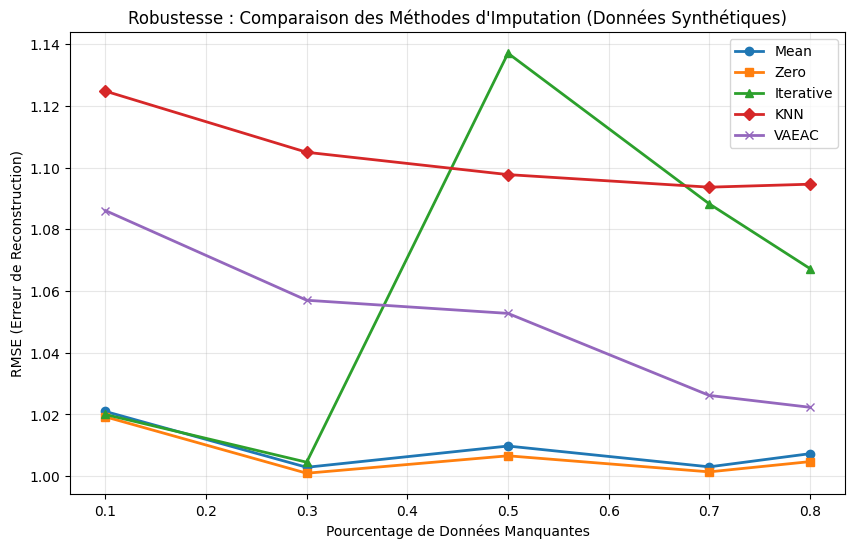

In [28]:

# ==========================================
# 1. Configuration de l'Expérience "Trash Data"
# ==========================================
print(">>> Démarrage de l'expérience de robustesse (Trash Data)...")

# Génération d'un dataset synthétique bruité (N=1000, M=15 features)
N_SAMPLES = 1000
N_FEATURES = 15
X_trash, _ = make_regression(n_samples=N_SAMPLES, n_features=N_FEATURES, noise=2.0, random_state=42)

# Normalisation (Important pour le VAE)
scaler_trash = StandardScaler()
X_trash = scaler_trash.fit_transform(X_trash)

# Liste des taux de manquants à tester
missing_rates = [0.1, 0.3, 0.5, 0.7, 0.8]
results = {'Mean': [], 'Zero': [], 'Iterative': [], 'KNN': [], 'VAEAC': []}

# ==========================================
# 2. Fonction d'entraînement adaptée pour l'expérience
# ==========================================
def train_vaeac_synthetic(X_in, epochs=30):
    """
    Entraîne un nouveau VAEAC spécifique aux dimensions de ce dataset synthétique.
    Utilise les classes VAEAC_Network et vaeac_loss déjà définies plus haut.
    """
    dim = X_in.shape[1]
    model = VAEAC_Network(input_dim=dim, width=32, depth=3, latent_dim=8).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # On remplit les trous par 0 pour l'entrée du réseau (ou moyenne, peu importe ici)
    X_filled = np.nan_to_num(X_in, nan=0.0)
    tensor_x = torch.FloatTensor(X_filled).to(DEVICE)
    loader = DataLoader(TensorDataset(tensor_x), batch_size=64, shuffle=True)

    model.train()
    for ep in range(epochs):
        for batch in loader:
            x_batch = batch[0]

            # Génération d'un masque d'entraînement (Bernoulli 0.5)
            # On réutilise votre MaskGenerator s'il est défini, sinon on fait simple:
            mask = torch.bernoulli(torch.full_like(x_batch, 0.5)).to(DEVICE)

            # Entrée masquée
            x_masked = x_batch.clone()
            x_masked[mask.bool()] = 0

            optimizer.zero_grad()
            # Forward pass (utilise votre classe VAEAC_Network)
            outs = model(x_batch, x_masked, mask)

            # Calcul de la loss (utilise votre fonction vaeac_loss)
            # outs contient : rec_mu, rec_logvar, f_mu, f_logvar, m_mu, m_logvar
            loss = vaeac_loss(x_batch, *outs, mask)

            loss.backward()
            optimizer.step()
    return model

# ==========================================
# 3. Boucle de Comparaison
# ==========================================
for rate in missing_rates:
    print(f"\n--- Test avec {rate*100:.0f}% de données manquantes ---")

    # Création du masque
    mask_miss = np.random.rand(*X_trash.shape) < rate
    X_miss = X_trash.copy()
    X_miss[mask_miss] = np.nan

    # --- A. Baselines (Moyenne, Zero, Iterative, KNN) ---
    # 1. Mean
    X_mean = SimpleImputer(strategy='mean').fit_transform(X_miss)
    rmse_mean = np.sqrt(np.mean((X_trash[mask_miss] - X_mean[mask_miss])**2))
    results['Mean'].append(rmse_mean)

    # 2. Zero
    X_zero = np.nan_to_num(X_miss, nan=0.0)
    rmse_zero = np.sqrt(np.mean((X_trash[mask_miss] - X_zero[mask_miss])**2))
    results['Zero'].append(rmse_zero)

    # 3. Iterative (Random Forest)
    X_iter = IterativeImputer(max_iter=10, random_state=42).fit_transform(X_miss)
    rmse_iter = np.sqrt(np.mean((X_trash[mask_miss] - X_iter[mask_miss])**2))
    results['Iterative'].append(rmse_iter)

    # 4. KNN
    X_knn = KNNImputer(n_neighbors=5).fit_transform(X_miss)
    rmse_knn = np.sqrt(np.mean((X_trash[mask_miss] - X_knn[mask_miss])**2))
    results['KNN'].append(rmse_knn)

    # --- B. VAEAC ---
    # Entraînement rapide sur ce dataset spécifique
    model_synth = train_vaeac_synthetic(X_miss, epochs=40)

    # Imputation (utilise votre fonction vaeac_impute existante ou logique similaire)
    # On passe des tenseurs remplis par 0
    X_in_tens = torch.FloatTensor(np.nan_to_num(X_miss, nan=0.0)).to(DEVICE)
    mask_tens = torch.FloatTensor(np.isnan(X_miss)).to(DEVICE)

    model_synth.eval()
    with torch.no_grad():
        # Masked Encoder Forward
        mu, logvar, skips = model_synth.forward_masked_encoder(X_in_tens, mask_tens)

        # Monte Carlo Sampling (K=5)
        preds = []
        for _ in range(5):
            z = model_synth.reparameterize(mu, logvar)
            rec, _ = model_synth.forward_decoder(z, skips)
            preds.append(rec.cpu().numpy())

        # Moyenne des reconstructions
        X_rec = np.mean(preds, axis=0)

    # On remplit les trous avec la prédiction VAEAC
    X_vaeac = X_miss.copy()
    X_vaeac[mask_miss] = X_rec[mask_miss]

    rmse_vaeac = np.sqrt(np.mean((X_trash[mask_miss] - X_vaeac[mask_miss])**2))
    results['VAEAC'].append(rmse_vaeac)

    print(f"RMSE -> Mean: {rmse_mean:.3f} | Iter: {rmse_iter:.3f} | VAEAC: {rmse_vaeac:.3f}")

# ==========================================
# 4. Affichage du Graphique
# ==========================================
plt.figure(figsize=(10, 6))
markers = ['o', 's', '^', 'D', 'x']
for i, (method, scores) in enumerate(results.items()):
    plt.plot(missing_rates, scores, marker=markers[i], label=method, linewidth=2)

plt.xlabel('Pourcentage de Données Manquantes')
plt.ylabel('RMSE (Erreur de Reconstruction)')
plt.title('Robustesse : Comparaison des Méthodes d\'Imputation (Données Synthétiques)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
# ==========================================
# Fonction Principale de Test (Celle qui manquait)
# ==========================================
def run_imputation_experiment(X_ground_truth, title="Analyse"):
    """
    Exécute la comparaison des méthodes sur un dataset donné.
    """
    missing_rates = [0.1, 0.3, 0.5, 0.7] # Taux de valeurs manquantes (NaN)

    results_rmse = {'Mean': [], 'Zero': [], 'Iterative': [], 'KNN': [], 'VAEAC': []}
    results_kl = {'Mean': [], 'Zero': [], 'Iterative': [], 'KNN': [], 'VAEAC': []}
    saved_imputations = {} # Pour le plot de densité à 50%

    print(f"\n>>> Traitement : {title} <<<")

    for rate in missing_rates:
        # Masque de valeurs manquantes (NaN)
        mask_miss = np.random.rand(*X_ground_truth.shape) < rate
        X_miss = X_ground_truth.copy()
        X_miss[mask_miss] = np.nan

        # --- Méthodes Classiques ---
        methods = {
            'Mean': SimpleImputer(strategy='mean'),
            'Zero': None,
            'Iterative': IterativeImputer(max_iter=10, random_state=42),
            'KNN': KNNImputer(n_neighbors=5)
        }

        X_imputed_current = {}

        for name, model in methods.items():
            if name == 'Zero':
                X_imp = np.nan_to_num(X_miss, nan=0.0)
            else:
                X_imp = model.fit_transform(X_miss)

            X_imputed_current[name] = X_imp

            # Calcul Métriques
            # RMSE calculé uniquement sur les parties manquantes
            if np.sum(mask_miss) > 0:
                mse = np.mean((X_ground_truth[mask_miss] - X_imp[mask_miss])**2)
                rmse = np.sqrt(mse)
            else:
                rmse = 0.0

            kl = calculate_kl_divergence(X_ground_truth, X_imp)

            results_rmse[name].append(rmse)
            results_kl[name].append(kl)

        # --- VAEAC (Intégration) ---
        try:
            # Note: Assurez-vous que train_vaeac_synthetic est bien défini plus haut
            model_synth = train_vaeac_synthetic(X_miss, epochs=30)

            X_in_tens = torch.FloatTensor(np.nan_to_num(X_miss, nan=0.0)).to(DEVICE)
            mask_tens = torch.FloatTensor(np.isnan(X_miss)).to(DEVICE)

            model_synth.eval()
            with torch.no_grad():
                mu, logvar, skips = model_synth.forward_masked_encoder(X_in_tens, mask_tens)
                preds = []
                for _ in range(5): # 5 passes MCMC pour lisser
                    z = model_synth.reparameterize(mu, logvar)
                    rec, _ = model_synth.forward_decoder(z, skips)
                    preds.append(rec.cpu().numpy())
                X_rec = np.mean(preds, axis=0)

            X_vaeac = X_miss.copy()
            X_vaeac[mask_miss] = X_rec[mask_miss]

            if np.sum(mask_miss) > 0:
                rmse_vaeac = np.sqrt(np.mean((X_ground_truth[mask_miss] - X_vaeac[mask_miss])**2))
            else:
                rmse_vaeac = 0.0

            kl_vaeac = calculate_kl_divergence(X_ground_truth, X_vaeac)

            results_rmse['VAEAC'].append(rmse_vaeac)
            results_kl['VAEAC'].append(kl_vaeac)
            X_imputed_current['VAEAC'] = X_vaeac

        except NameError:
            print("Attention: Fonction train_vaeac_synthetic non trouvée.")
            results_rmse['VAEAC'].append(0)
            results_kl['VAEAC'].append(0)
        except Exception as e:
            print(f"Erreur VAEAC: {e}")
            results_rmse['VAEAC'].append(0)
            results_kl['VAEAC'].append(0)

        if rate == 0.5:
            saved_imputations = X_imputed_current

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Résultats pour : {title}", fontsize=16)

    # RMSE
    for name, scores in results_rmse.items():
        if len(scores) > 0: axes[0].plot(missing_rates, scores, marker='o', label=name)
    axes[0].set_title("RMSE (Reconstruction)")
    axes[0].set_xlabel("% Manquant (NaN)")
    axes[0].set_ylabel("RMSE")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # KL
    for name, scores in results_kl.items():
         if len(scores) > 0: axes[1].plot(missing_rates, scores, marker='s', label=name)
    axes[1].set_title("Divergence KL (Distribution)")
    axes[1].set_xlabel("% Manquant (NaN)")
    axes[1].set_ylabel("KL")
    axes[1].grid(True, alpha=0.3)

    # Densité
    if len(saved_imputations) > 0:
        feature_idx = 0
        sns.kdeplot(X_ground_truth[:, feature_idx], ax=axes[2], color='black', fill=True, alpha=0.1, label='Vrai', linewidth=3)
        colors = {'Mean': 'red', 'Zero': 'purple', 'Iterative': 'green', 'KNN': 'orange', 'VAEAC': 'blue'}
        for name, X_imp in saved_imputations.items():
            sns.kdeplot(X_imp[:, feature_idx], ax=axes[2], color=colors.get(name, 'gray'), label=name, linestyle='--')
        axes[2].set_title("Densité (Taux Manquant=50%)")
        axes[2].legend()

    plt.tight_layout()
    plt.show()


>>> Traitement : Données IID (Gaussiennes) <<<


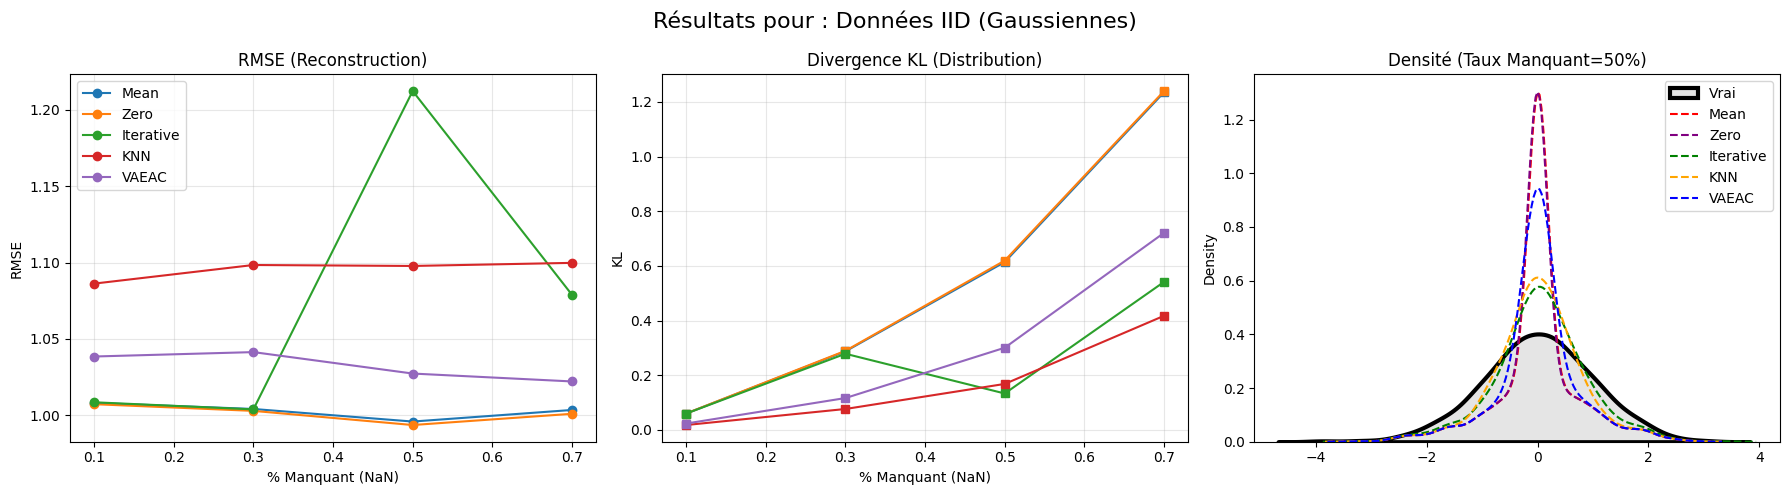


>>> Traitement : Données Mélange (GMM) <<<


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


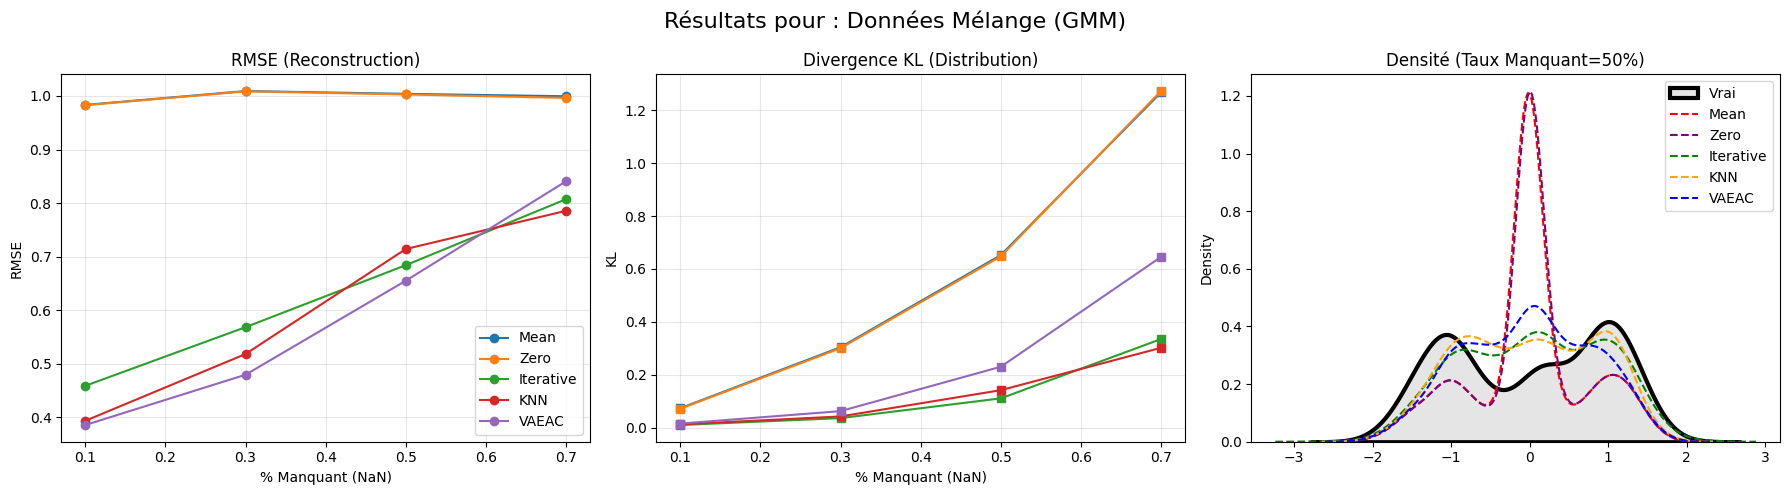


>>> Traitement : Données Copule (Non-linéaire) <<<


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


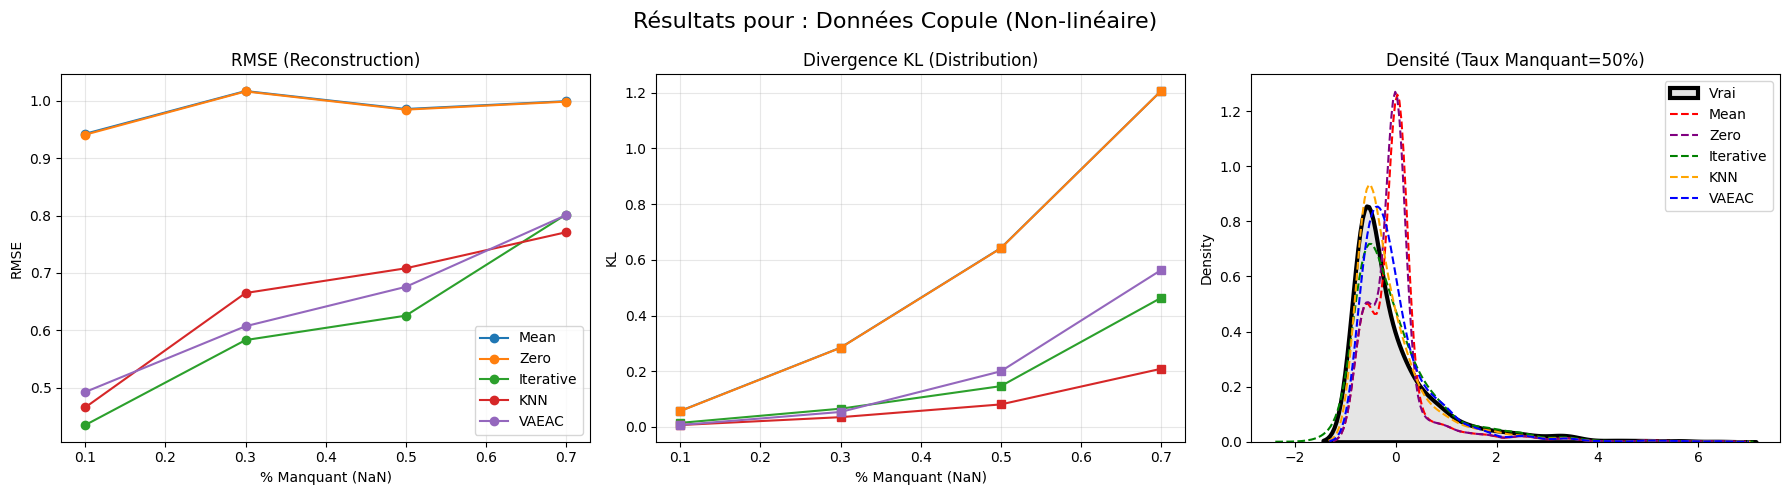

In [30]:
# 1. Données IID (Baseline)
X_iid = generate_data(data_type='iid')
run_imputation_experiment(X_iid, title="Données IID (Gaussiennes)")

# 2. Données Mélange (Multimodal)
X_mix = generate_data(data_type='mixture')
run_imputation_experiment(X_mix, title="Données Mélange (GMM)")

# 3. Données Copule
X_cop = generate_data(data_type='copula')
run_imputation_experiment(X_cop, title="Données Copule (Non-linéaire)")


>>> Démarrage du Test de Sparsité (Influence des Zéros) <<<
  -> Test avec 0% de zéros dans la vérité terrain...
  -> Test avec 20% de zéros dans la vérité terrain...
  -> Test avec 40% de zéros dans la vérité terrain...
  -> Test avec 60% de zéros dans la vérité terrain...
  -> Test avec 80% de zéros dans la vérité terrain...


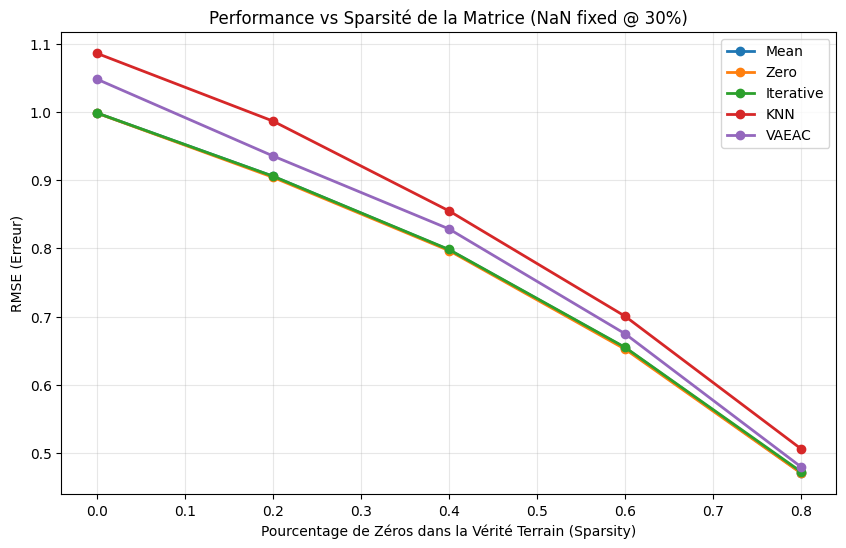

In [24]:
def run_sparsity_test():
    sparsity_levels = [0.0, 0.2, 0.4, 0.6, 0.8] # % de la matrice qui est VRAIMENT zéro
    fixed_missing_rate = 0.3 # On cache 30% des données

    rmse_by_sparsity = {'Mean': [], 'Zero': [], 'Iterative': [], 'KNN': [], 'VAEAC': []}

    print("\n>>> Démarrage du Test de Sparsité (Influence des Zéros) <<<")

    for sp in sparsity_levels:
        print(f"  -> Test avec {sp*100:.0f}% de zéros dans la vérité terrain...")
        # On génère des données IID mais avec beaucoup de zéros
        X_sparse = generate_data(data_type='iid', sparsity=sp)

        # On crée les trous (NaN)
        mask_miss = np.random.rand(*X_sparse.shape) < fixed_missing_rate
        X_miss = X_sparse.copy()
        X_miss[mask_miss] = np.nan

        # --- Modèles ---
        methods = {
            'Mean': SimpleImputer(strategy='mean'),
            'Zero': None, # Impute par 0
            'Iterative': IterativeImputer(max_iter=10),
            'KNN': KNNImputer(n_neighbors=5)
        }

        for name, model in methods.items():
            if name == 'Zero':
                X_imp = np.nan_to_num(X_miss, nan=0.0)
            else:
                X_imp = model.fit_transform(X_miss)

            rmse = np.sqrt(np.mean((X_sparse[mask_miss] - X_imp[mask_miss])**2))
            rmse_by_sparsity[name].append(rmse)

        # VAEAC
        try:
            model_synth = train_vaeac_synthetic(X_miss, epochs=20) # Moins d'epochs pour aller vite
            X_in_tens = torch.FloatTensor(np.nan_to_num(X_miss, nan=0.0)).to(DEVICE)
            mask_tens = torch.FloatTensor(np.isnan(X_miss)).to(DEVICE)
            model_synth.eval()
            with torch.no_grad():
                mu, logvar, skips = model_synth.forward_masked_encoder(X_in_tens, mask_tens)
                z = model_synth.reparameterize(mu, logvar)
                rec, _ = model_synth.forward_decoder(z, skips)
                X_rec = rec.cpu().numpy()

            X_vaeac = X_miss.copy()
            X_vaeac[mask_miss] = X_rec[mask_miss]
            rmse_vaeac = np.sqrt(np.mean((X_sparse[mask_miss] - X_vaeac[mask_miss])**2))
            rmse_by_sparsity['VAEAC'].append(rmse_vaeac)
        except:
             rmse_by_sparsity['VAEAC'].append(0)

    # --- Plot Sparsity ---
    plt.figure(figsize=(10, 6))
    for name, scores in rmse_by_sparsity.items():
        plt.plot(sparsity_levels, scores, marker='o', label=name, linewidth=2)

    plt.title(f"Performance vs Sparsité de la Matrice (NaN fixed @ {fixed_missing_rate*100:.0f}%)")
    plt.xlabel("Pourcentage de Zéros dans la Vérité Terrain (Sparsity)")
    plt.ylabel("RMSE (Erreur)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Lancer le test spécifique
run_sparsity_test()

taux testés : [0.05 0.15 0.25 0.35 0.45]
>>> Démarrage de l'analyse détaillée (Densité par Taux)...

--- Traitement Taux : 5% ---
  VAEAC -> RMSE: 1.021 | KL: 0.004

--- Traitement Taux : 15% ---
  VAEAC -> RMSE: 1.052 | KL: 0.023

--- Traitement Taux : 25% ---
  VAEAC -> RMSE: 1.058 | KL: 0.065

--- Traitement Taux : 35% ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


  VAEAC -> RMSE: 1.035 | KL: 0.124

--- Traitement Taux : 45% ---


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


  VAEAC -> RMSE: 1.043 | KL: 0.202


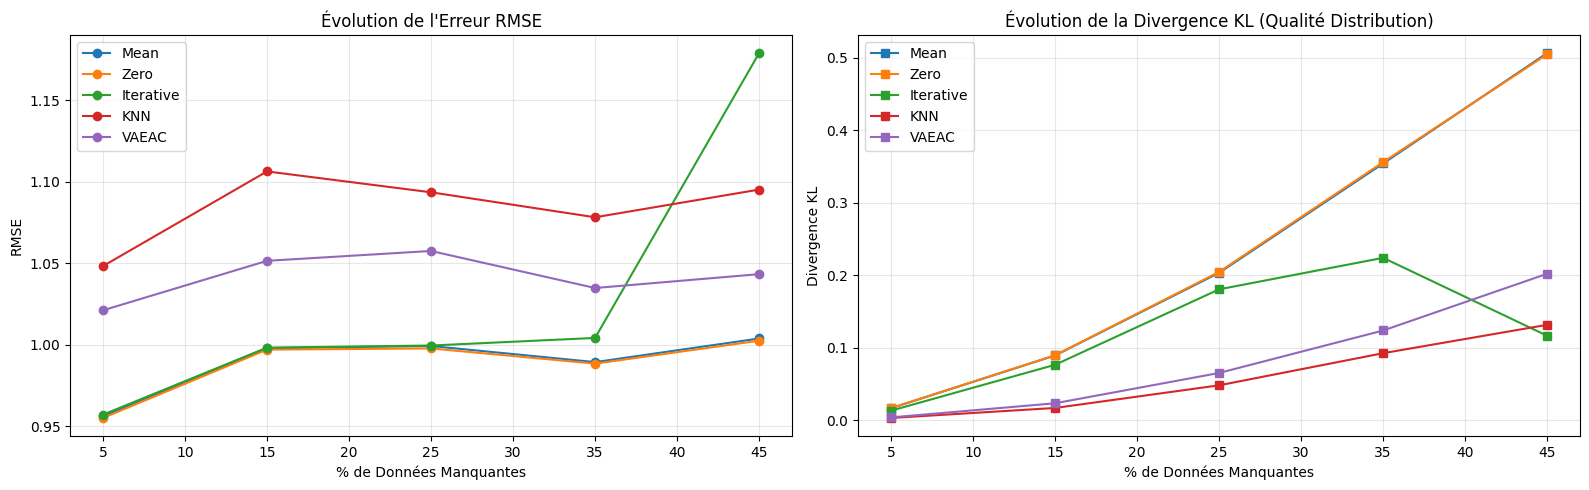

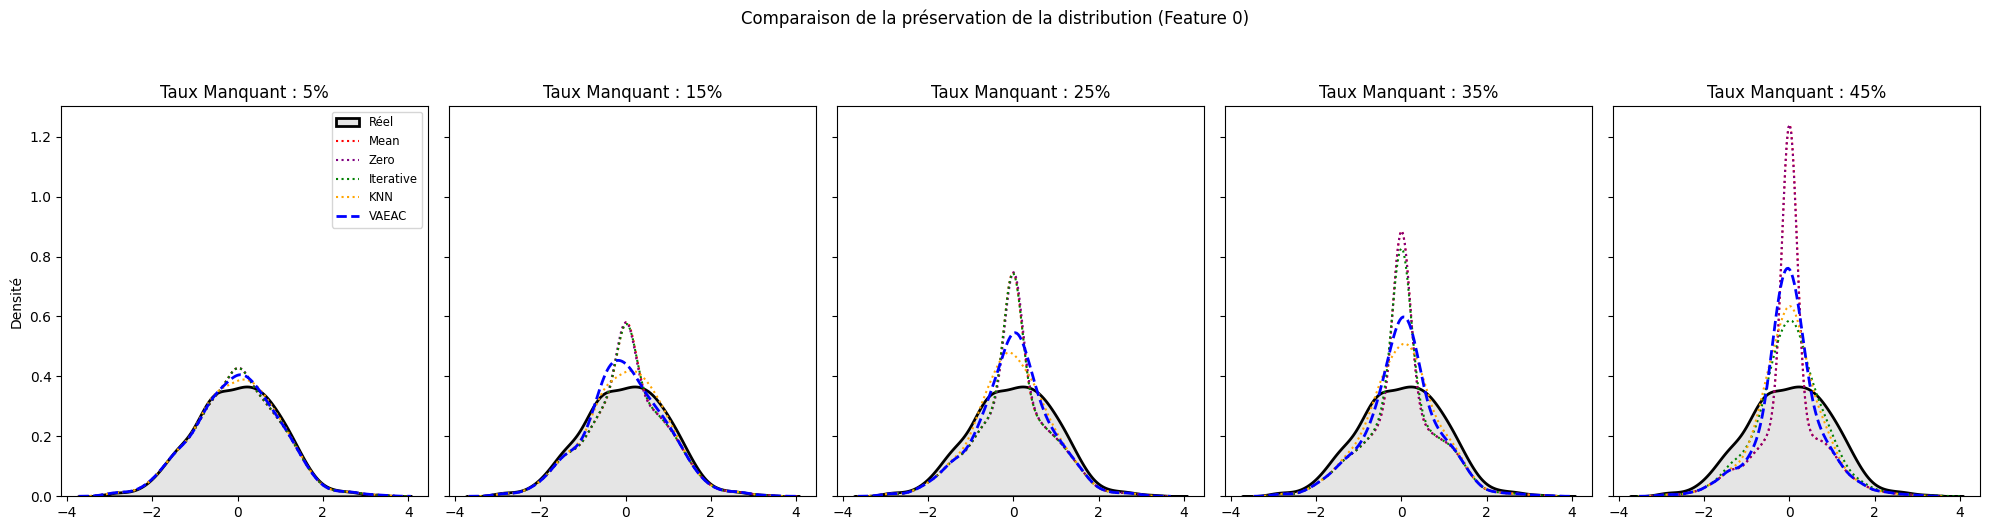

In [25]:
from scipy.stats import entropy



missing_rates = np.arange(0.05, 0.55, 0.10) # [0.05, 0.15, 0.25, 0.35, 0.45]
print(f"taux testés : {missing_rates}")

results_rmse = {'Mean': [], 'Zero': [], 'Iterative': [], 'KNN': [], 'VAEAC': []}
results_kl = {'Mean': [], 'Zero': [], 'Iterative': [], 'KNN': [], 'VAEAC': []}

# Pour stocker les données afin de tracer les densités plus tard
# Structure : density_data[rate][method] = 1D array of feature 0
density_data = {rate: {} for rate in missing_rates}

print(">>> Démarrage de l'analyse détaillée (Densité par Taux)...")

# ==========================================
# 2. Boucle Expérimentale
# ==========================================
for rate in missing_rates:
    print(f"\n--- Traitement Taux : {rate*100:.0f}% ---")

    # Génération masque et données manquantes
    mask_miss = np.random.rand(*X_trash.shape) < rate
    X_miss = X_trash.copy()
    X_miss[mask_miss] = np.nan

    # --- Méthodes Classiques ---
    methods = {
        'Mean': SimpleImputer(strategy='mean'),
        'Zero': None,
        'Iterative': IterativeImputer(max_iter=10, random_state=42),
        'KNN': KNNImputer(n_neighbors=5)
    }

    for name, model in methods.items():
        if name == 'Zero':
            X_imp = np.nan_to_num(X_miss, nan=0.0)
        else:
            X_imp = model.fit_transform(X_miss)

        # Calcul métriques
        rmse = np.sqrt(np.mean((X_trash[mask_miss] - X_imp[mask_miss])**2))
        kl = calculate_kl_divergence(X_trash, X_imp)

        results_rmse[name].append(rmse)
        results_kl[name].append(kl)

        # Sauvegarde pour le plot de densité (on prend la feature 0)
        density_data[rate][name] = X_imp[:, 0]

    # --- Méthode VAEAC ---
    # Ré-entraînement rapide spécifique à ce taux (pour être juste)
    model_synth = train_vaeac_synthetic(X_miss, epochs=30)

    X_in_tens = torch.FloatTensor(np.nan_to_num(X_miss, nan=0.0)).to(DEVICE)
    mask_tens = torch.FloatTensor(np.isnan(X_miss)).to(DEVICE)

    model_synth.eval()
    with torch.no_grad():
        mu, logvar, skips = model_synth.forward_masked_encoder(X_in_tens, mask_tens)
        preds = []
        for _ in range(5):
            z = model_synth.reparameterize(mu, logvar)
            rec, _ = model_synth.forward_decoder(z, skips)
            preds.append(rec.cpu().numpy())
        X_rec = np.mean(preds, axis=0)

    X_vaeac = X_miss.copy()
    X_vaeac[mask_miss] = X_rec[mask_miss]

    # Métriques VAEAC
    rmse_vaeac = np.sqrt(np.mean((X_trash[mask_miss] - X_vaeac[mask_miss])**2))
    kl_vaeac = calculate_kl_divergence(X_trash, X_vaeac)

    results_rmse['VAEAC'].append(rmse_vaeac)
    results_kl['VAEAC'].append(kl_vaeac)
    density_data[rate]['VAEAC'] = X_vaeac[:, 0]

    print(f"  VAEAC -> RMSE: {rmse_vaeac:.3f} | KL: {kl_vaeac:.3f}")

# ==========================================
# 3. Affichage Global
# ==========================================
# Figure 1 : Métriques (RMSE et KL)
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 5))

# Plot RMSE
for name, scores in results_rmse.items():
    axes1[0].plot(missing_rates*100, scores, marker='o', label=name)
axes1[0].set_title("Évolution de l'Erreur RMSE")
axes1[0].set_xlabel("% de Données Manquantes")
axes1[0].set_ylabel("RMSE")
axes1[0].legend()
axes1[0].grid(True, alpha=0.3)

# Plot KL
for name, scores in results_kl.items():
    axes1[1].plot(missing_rates*100, scores, marker='s', label=name)
axes1[1].set_title("Évolution de la Divergence KL (Qualité Distribution)")
axes1[1].set_xlabel("% de Données Manquantes")
axes1[1].set_ylabel("Divergence KL")
axes1[1].legend()
axes1[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Figure 2 : Densités par pourcentage (Grille)
n_cols = len(missing_rates)
fig2, axes2 = plt.subplots(1, n_cols, figsize=(4*n_cols, 5), sharey=True)

colors = {'Mean': 'red', 'Zero': 'purple', 'Iterative': 'green', 'KNN': 'orange', 'VAEAC': 'blue'}

for i, rate in enumerate(missing_rates):
    ax = axes2[i]

    # Vraie distribution (Fond)
    sns.kdeplot(X_trash[:, 0], ax=ax, color='black', fill=True, alpha=0.1, linewidth=2, label='Réel')

    # Distributions imputées
    for method_name, data_col in density_data[rate].items():
        # On ne plot pas tout pour garder lisible, ou on plot tout en pointillé
        style = '--' if method_name == 'VAEAC' else ':'
        width = 2 if method_name == 'VAEAC' else 1.5
        sns.kdeplot(data_col, ax=ax, color=colors.get(method_name, 'gray'),
                    linestyle=style, linewidth=width, label=method_name)

    ax.set_title(f"Taux Manquant : {rate*100:.0f}%")
    if i == 0:
        ax.set_ylabel("Densité")
        ax.legend(loc='upper right', fontsize='small')
    else:
        ax.set_ylabel("")

plt.suptitle("Comparaison de la préservation de la distribution (Feature 0)", y=1.05)
plt.tight_layout()
plt.show()